In [45]:

import pandas as pd
import pyodbc
from typing import List, Union
#Parameters
ANALYTICS_PATH =  'G:/Meu Drive/Estudos/Pos-graduacao - Ciencia de Dados e  Analytics/Sprints/Sprint III - Data Engineering/MVP/wild fire analysis along last decade/Assets/analytics/'
IMAGES_PATH = ANALYTICS_PATH + 'imgs/'

#configuring odbc
server = 'wildfire-data-analytics-server.database.windows.net' 
database = 'wildfire-data-analytics' 
username = 'lucasvittal' 
password = 'Lv300699@$'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

#functions 


def plot_dfChart(df: pd.DataFrame, xVar: str, yVar: Union[ str, List[str] ], chart_type:str = 'bar', figsize=(40,20),
                 xLabel: str = None, yLabel: str= None , title:str = None,
                 labelsFontSize: int =30, xLabelRotation:int = 45, xTicksSpace=1,
                 ticksFontSize=20 ,titleFonteSize: int =40):

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=figsize)

    # Read the CSV file into a DataFrame

    # Create the bar chart using the DataFrame and the specified axis
    df[yVar].plot(kind= chart_type, ax=ax)

    # Add labels and title

    if chart_type != 'barh':
        ax.set_xlabel(xLabel, fontsize=labelsFontSize)
        ax.set_ylabel(yLabel, fontsize=labelsFontSize)
        ax.set_title(title, fontsize=titleFonteSize)

        # Set the x-axis tick labels
        xticks = list(df[xVar])
        tick_positions = range(0, len(xticks), xTicksSpace)  # Increase space every 5 ticks, you can adjust this value
        tick_labels = [xticks[i] for i in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=xLabelRotation)
        ax.set_xticklabels(tick_labels, rotation=xLabelRotation)
    else:
        ax.set_xlabel(yLabel, fontsize=labelsFontSize)
        ax.set_ylabel(xLabel, fontsize=labelsFontSize)
        ax.set_title(title, fontsize=titleFonteSize)

        # Set the x-axis tick labels
        xticks = list(df[xVar])
        ax.set_yticklabels(xticks, rotation=xLabelRotation)

        tick_positions = range(0, len(xticks), xTicksSpace)  # Increase space every 5 ticks, you can adjust this value
        tick_labels = [xticks[i] for i in tick_positions]

        # Set the x-axis tick positions and labels
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels, rotation=xLabelRotation)
        ax.set_yticklabels(tick_labels, rotation=xLabelRotation)

    #set labelsFontsize
    ax.tick_params(axis='both', labelsize=ticksFontSize)

    return fig, ax

## 

**A evolução das queimadas ao longo do tempo e o perfil desse fenômeno nos países mais afetados**

### **Total Evolution**

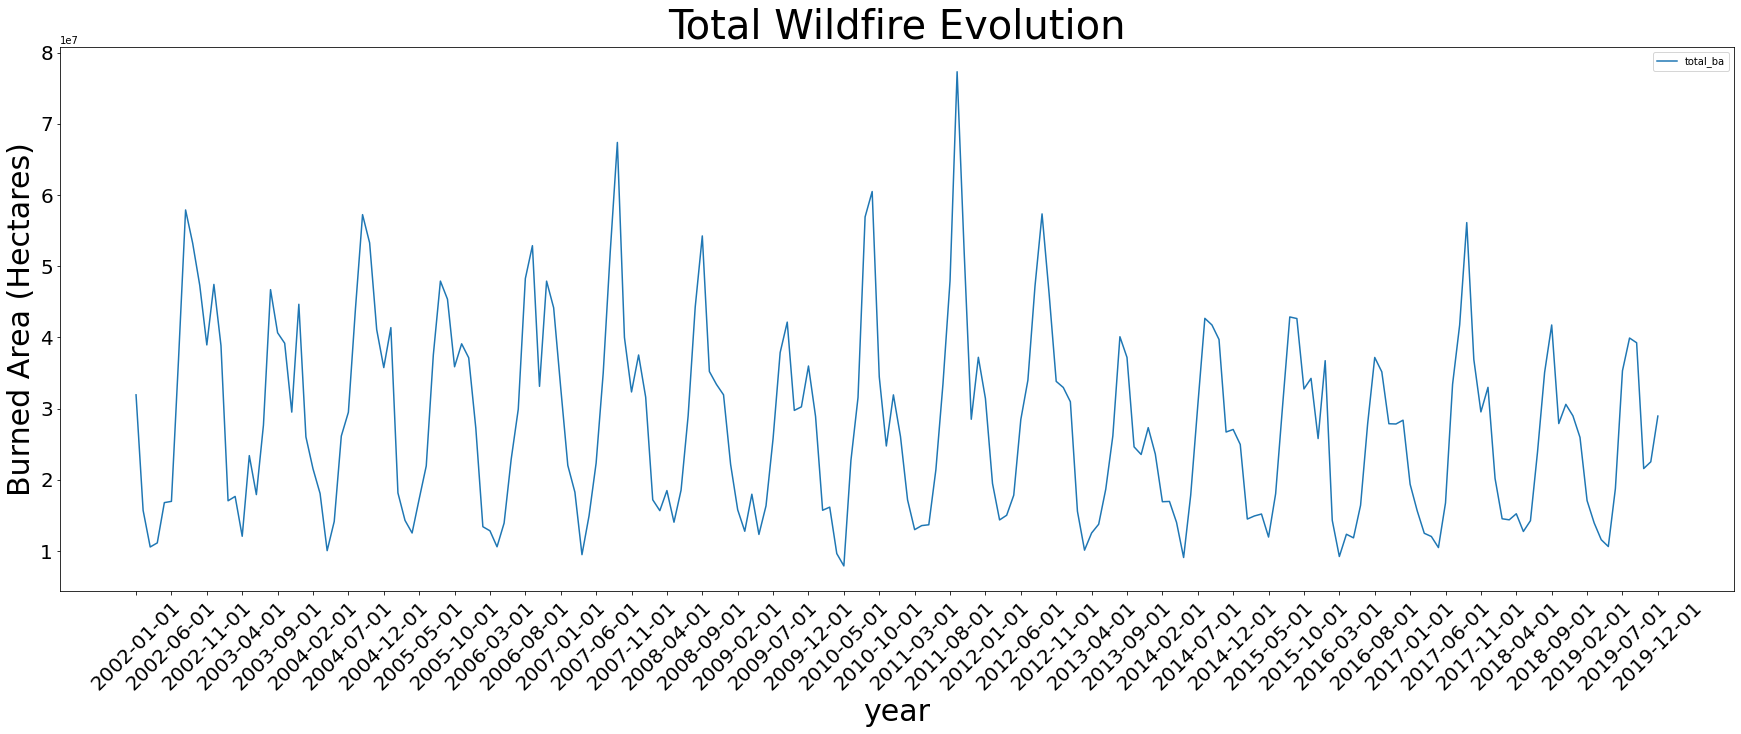

(<Figure size 2160x720 with 1 Axes>,
 <Axes: title={'center': 'Total Wildfire Evolution'}, xlabel='year', ylabel='Burned Area (Hectares)'>)

In [22]:
import matplotlib.pyplot as plt

query = """

SELECT 
    date, sum(cropland_ba + forest_ba + grass_and_shrubland_ba + wetlands_ba + settlement_ba +other_ba) as total_ba
FROM
    BurnedAreaEvolution
GROUP BY
    date
ORDER BY
    date
;
"""
totalWildFireEvolution = pd.read_sql(query, cnxn)
totalWildFireEvolution.head(10)


plot_dfChart(totalWildFireEvolution, 'date', ['total_ba'], figsize=(30,10), title="Total Wildfire Evolution",
             xLabel='year', yLabel='Burned Area (Hectares)', chart_type='line', xTicksSpace=5)

Não se observa nenhuma tendeencia de queda, entretanto chama a atenção o fato das queimadas possuirem umas sazionalidade muito bem definda, tendo minimos e maximos em periodos aproximadamente fixos

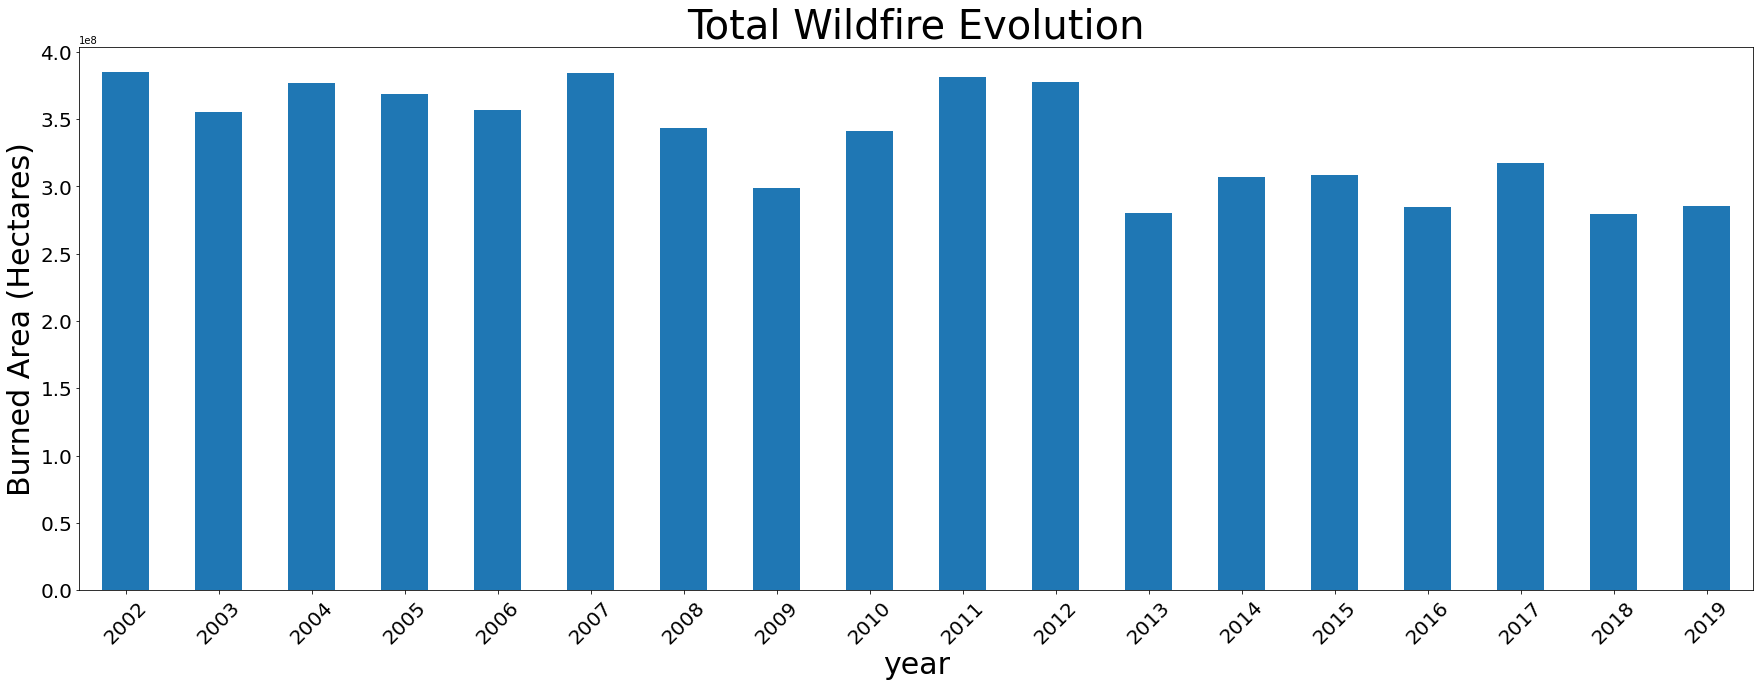

In [25]:

import matplotlib.pyplot as plt

query = """
WITH totalBurnedArea as (
SELECT 
    Year(date) as year, (cropland_ba + forest_ba + grass_and_shrubland_ba + wetlands_ba + settlement_ba +other_ba) as burned_area 
FROM 
    dbo.BurnedAreaEvolution

    )
SELECT 
    year, sum(burned_area) as total_ba
FROM
    totalBurnedArea
GROUP BY
    year
ORDER BY
    year
;
"""
totalWildFireEvolution = pd.read_sql(query, cnxn)
totalWildFireEvolution.head(10)


plot_dfChart(totalWildFireEvolution, 'year', 'total_ba', figsize=(30,10), title="Total Wildfire Evolution", xLabel='year', yLabel='Burned Area (Hectares)')
plt.savefig(IMAGES_PATH + 'total_wild_fire_evolution_year.png')

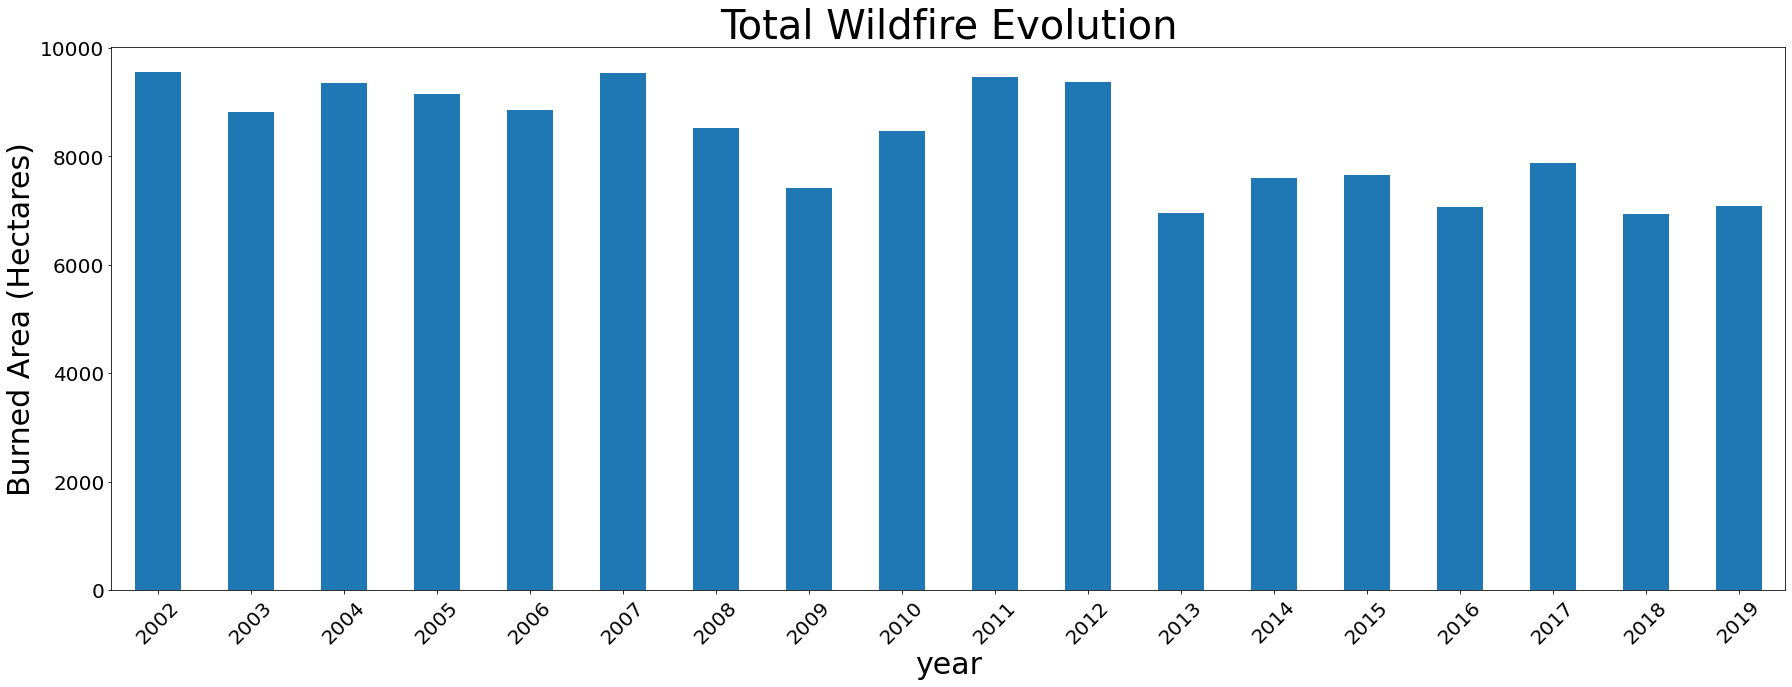

(<Figure size 2160x720 with 1 Axes>,
 <Axes: title={'center': 'Total Wildfire Evolution'}, xlabel='year', ylabel='Burned Area (Hectares)'>)

In [24]:

import matplotlib.pyplot as plt

query = """
WITH totalBurnedArea as (
SELECT 
    Year(date) as year, (cropland_ba + forest_ba + grass_and_shrubland_ba + wetlands_ba + settlement_ba +other_ba) as burned_area 
FROM 
    dbo.BurnedAreaEvolution

    )
SELECT 
    year, avg(burned_area) as total_ba
FROM
    totalBurnedArea
GROUP BY
    year
ORDER BY
    year
;
"""
totalWildFireEvolution = pd.read_sql(query, cnxn)
totalWildFireEvolution.head(10)


plot_dfChart(totalWildFireEvolution, 'year', 'total_ba', figsize=(30,10), title="Total Wildfire Evolution", xLabel='year', yLabel='Burned Area (Hectares)')

Globlamente falando não se observa um crescimento na evolução das queimadas em termos de area queimadas, nem em termos do total e  nem em termos de média anual. Mas o que dizer dos países mais afetados?

### **Top 8 países mais afetados pelas queimadas**

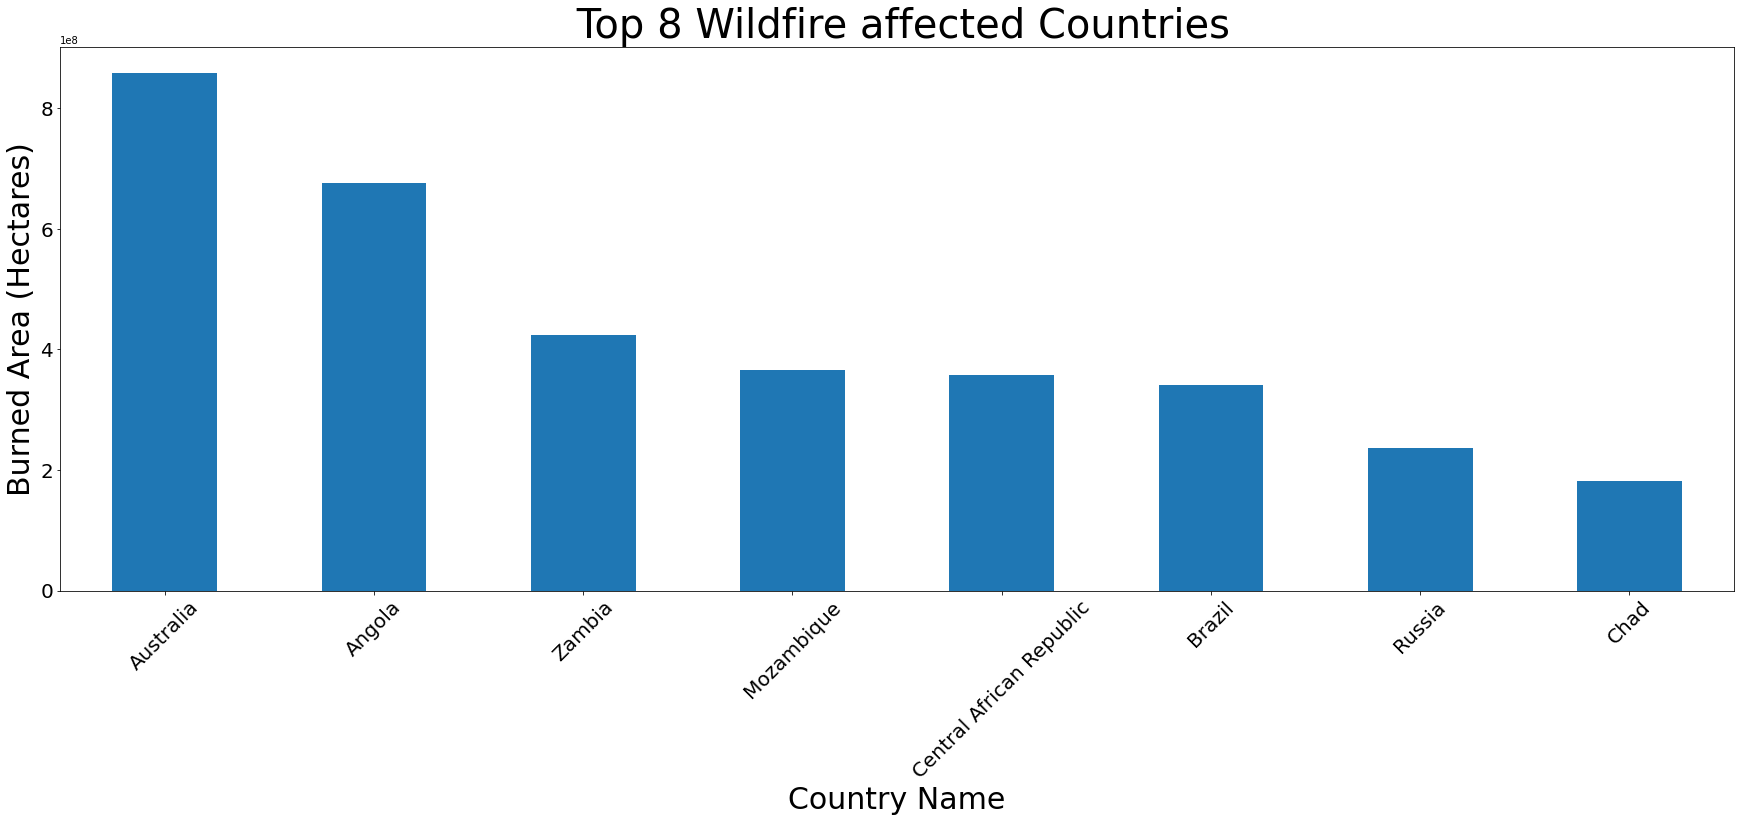

In [26]:
query = """
WITH totalBurnedArea AS (
    SELECT
        LEFT(region_code, 3) AS country,
        (cropland_ba + forest_ba + grass_and_shrubland_ba + wetlands_ba + settlement_ba + other_ba) AS burned_area
    FROM
        dbo.BurnedAreaEvolution
)
SELECT TOP 8
    c.name AS country_name,
    c.code AS country_code,
    SUM(tba.burned_area) AS total_ba
FROM
    totalBurnedArea AS tba
INNER JOIN
    country AS c
ON
    tba.country = c.code
GROUP BY
    c.name,c.code
ORDER BY
    total_ba DESC;
"""
top8AffectedCountries_df = pd.read_sql(query, cnxn)
top8AffectedCountries_df


plot_dfChart(top8AffectedCountries_df, 'country_name', 'total_ba', figsize=(30,10), title=" Top 8 Wildfire affected Countries", xLabel='Country Name', yLabel='Burned Area (Hectares)')
plt.savefig(IMAGES_PATH + 'top_8_most_affected_countries.png')

O que chama  atenção é que diferentemente do que se pensava o país que mais sofre com queimadas não é nem o estados unidos e nem o canadá no período de cobertura dos dados(2002 a 2019) e sim a Austrália.  Entrentanto o que foi noticiado nesse período foi o que acontecerá no EUA ,  Canadá e Brasil, dando a entender que as queiamdas são mais intensas nesse países. Ao avaliar os dados percebe-se que as noticias que nos chegam distorcem a visão da realidade a cerca deste fenômeno de foram significativa.

agora avaliando  o total acumulado anual em cada um desses paises....

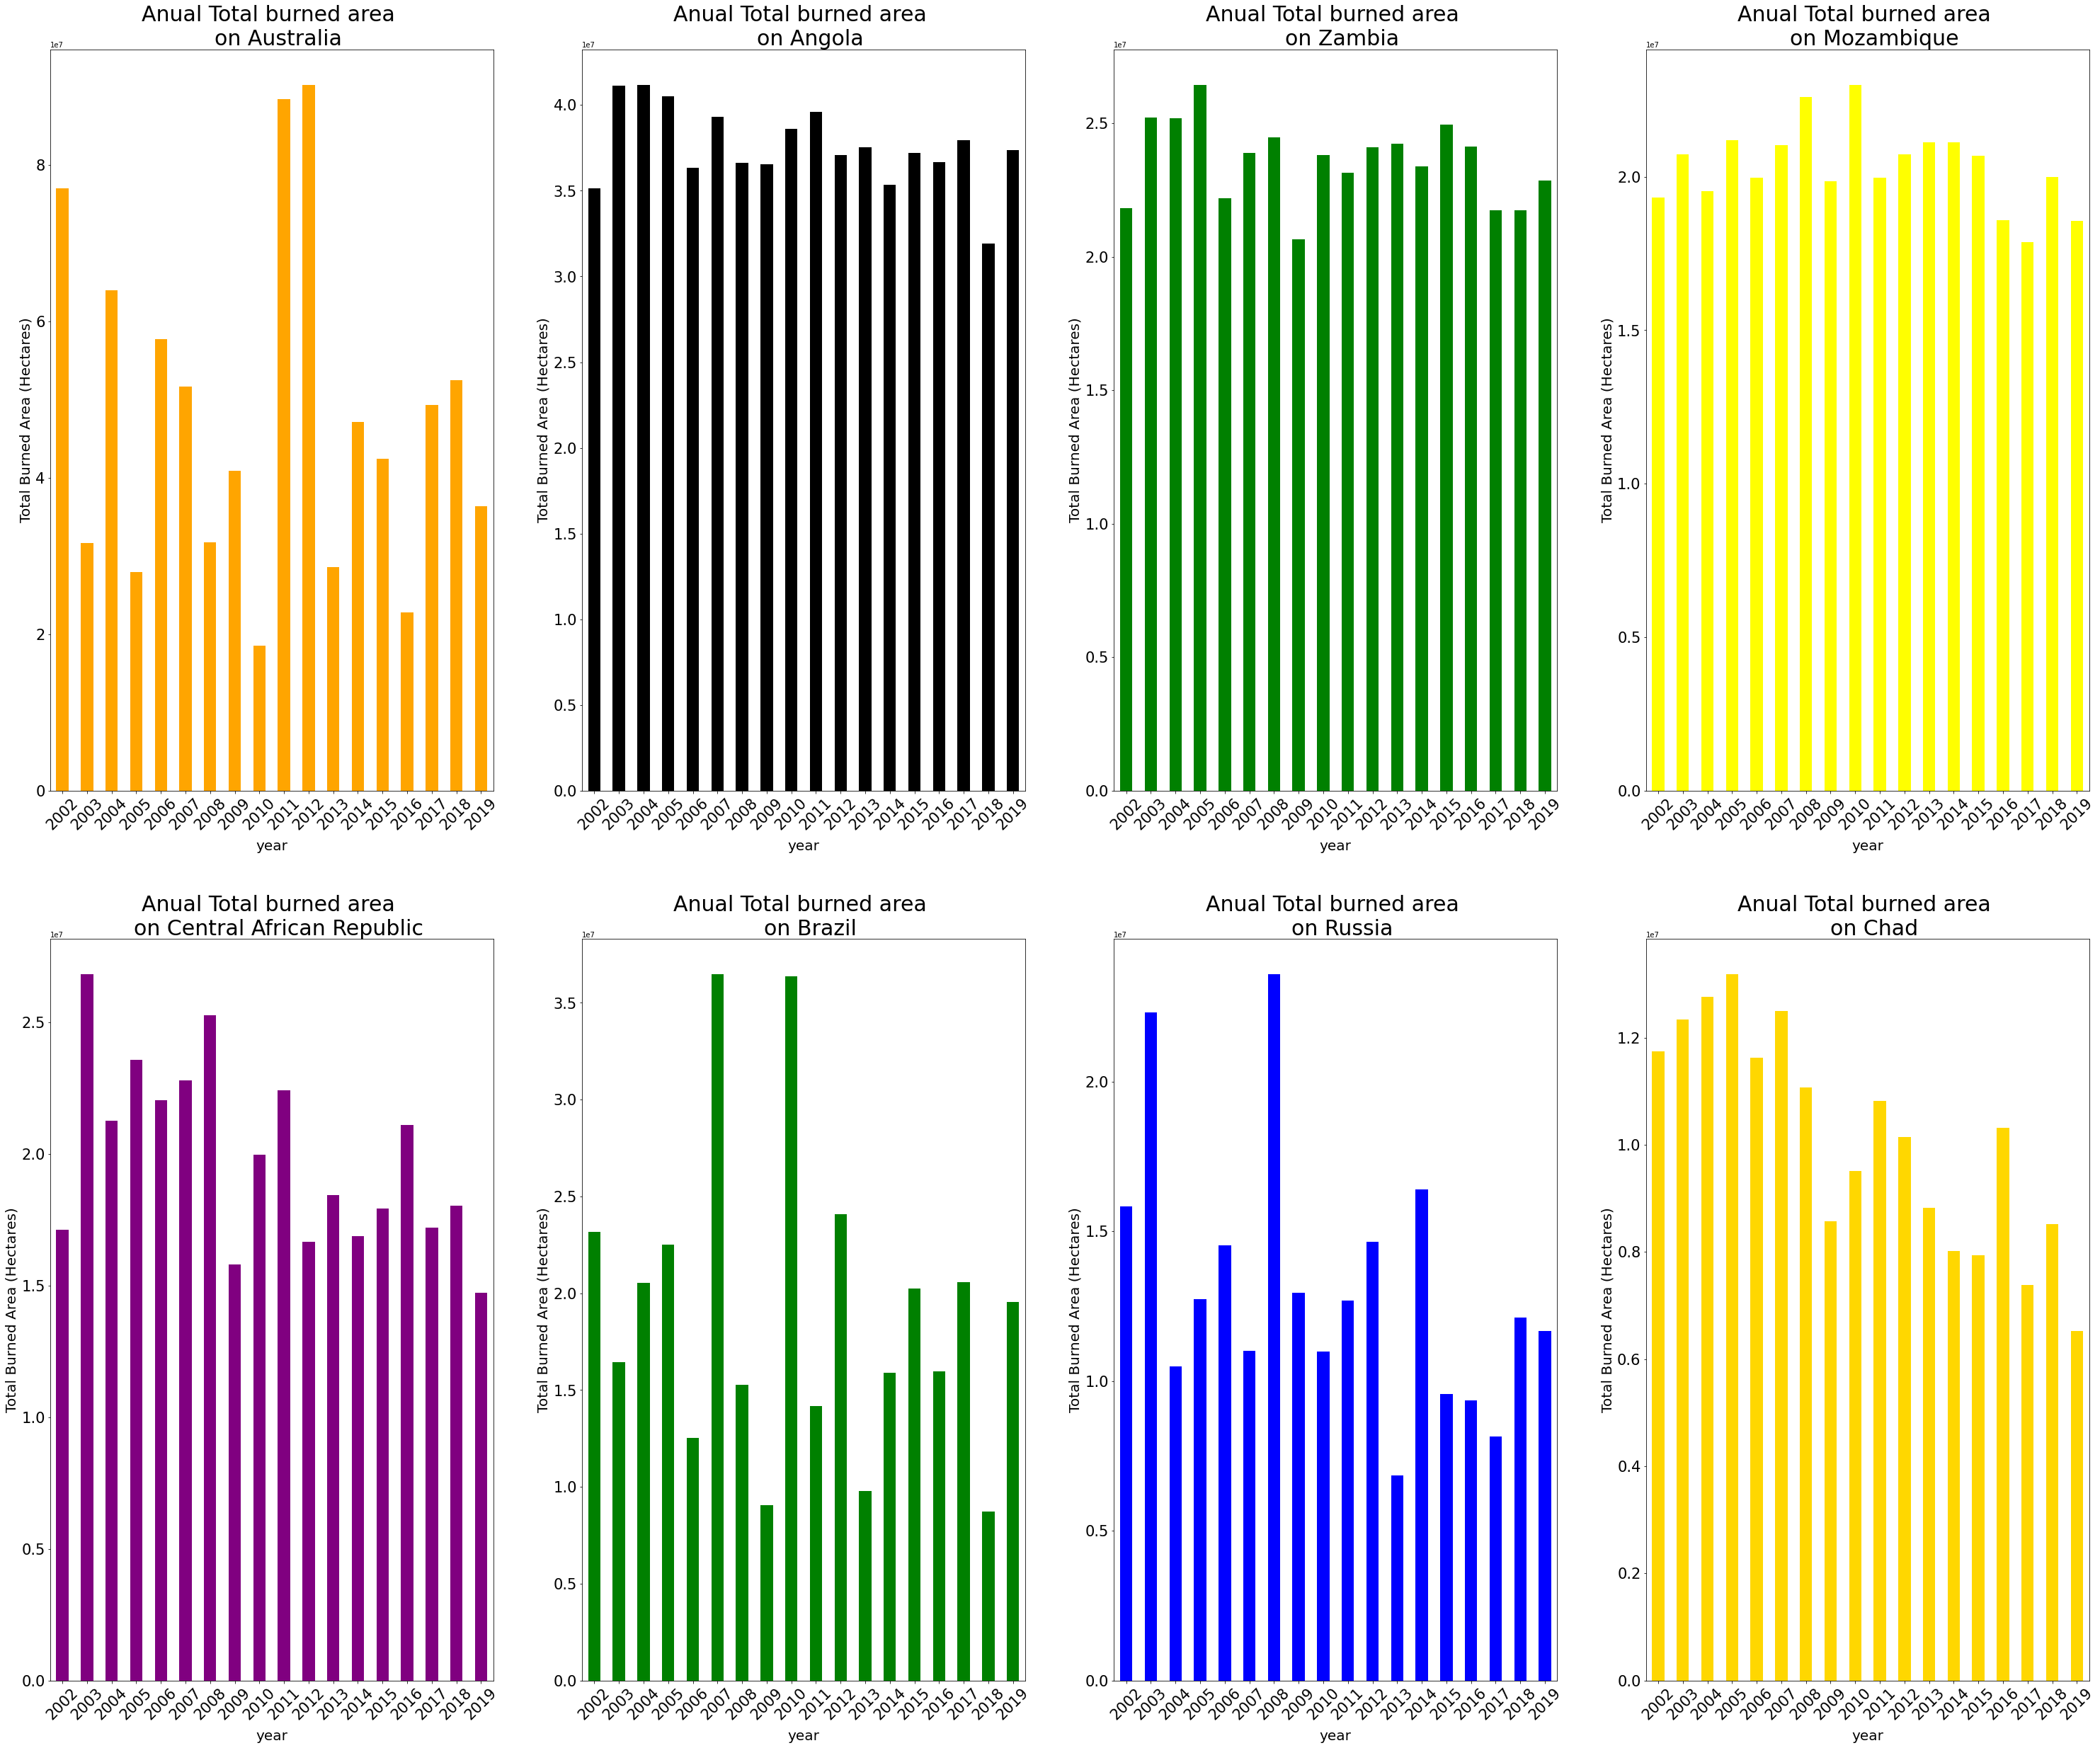

In [27]:
fig, axs = plt.subplots(2,4)
axs = [ax for axs_lst in axs for ax in axs_lst]
labelsFontSize = 20
titleFonteSize = 30 
xTicksSpace = 1 
xLabelRotation = 45
ticksFontSize = 21
country_colors = ['orange','black','green', 'yellow','purple','green', 'blue', 'gold']

for i, COU in  enumerate(top8AffectedCountries_df['country_code'].unique()):

    country = top8AffectedCountries_df['country_name'].unique()[i]
    query=f"""
        WITH totalBurnedArea AS (
            SELECT
                YEAR(date) as year,
                LEFT(region_code, 3) AS country,
                (cropland_ba + forest_ba + grass_and_shrubland_ba + wetlands_ba + settlement_ba + other_ba) AS burned_area
            FROM
                dbo.BurnedAreaEvolution as b
        )

        SELECT
        year, c.code as country_code, c.name AS country_name,
            SUM(tba.burned_area) AS total_ba
        FROM
            totalBurnedArea AS tba
        INNER JOIN
            country AS c
        ON
            tba.country = c.code
        WHERE 
            c.code = '{COU}'
        GROUP BY
            year, c.code,c.name 
        ORDER BY
            year ASC;
    """
    countryAnualAcumulatedBA_df =  pd.read_sql(query, cnxn)


    #plot
    countryAnualAcumulatedBA_df['total_ba'].plot(kind= 'bar', ax=axs[i], figsize= (30,10), color=country_colors[i])

    # Add labels and title
    axs[i].set_xlabel('year', fontsize=labelsFontSize, labelpad=10)
    axs[i].set_ylabel('Total Burned Area (Hectares)', fontsize=labelsFontSize)
    axs[i].set_title(f'Anual Total burned area \n  on {country}', fontsize=titleFonteSize)

    # Set the x-axis tick labels
    xticks = list(countryAnualAcumulatedBA_df['year'])
    axs[i].set_xticklabels(xticks, rotation=xLabelRotation)

    tick_positions = range(0, len(xticks), xTicksSpace)  # Increase space every 5 ticks, you can adjust this value
    tick_labels = [xticks[i] for i in tick_positions]

    # Set the x-axis tick positions and labels
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels, rotation=xLabelRotation)
    axs[i].set_xticklabels(tick_labels, rotation=xLabelRotation)

    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)
    plt.subplots_adjust(left=0.1, right=0.9, top=2, bottom=0.4)

#savings subplots
fig.set_size_inches(50, 20)
fig.savefig(IMAGES_PATH + 'ba_distribution_top8_countries.png', dpi=300, bbox_inches='tight')

Analisando os paises mais afetados o que se observa que a grande maioria segue a mesma tendencia global, tirano o Chad, todos os outros países   
 tem um tendencia de establilidade.

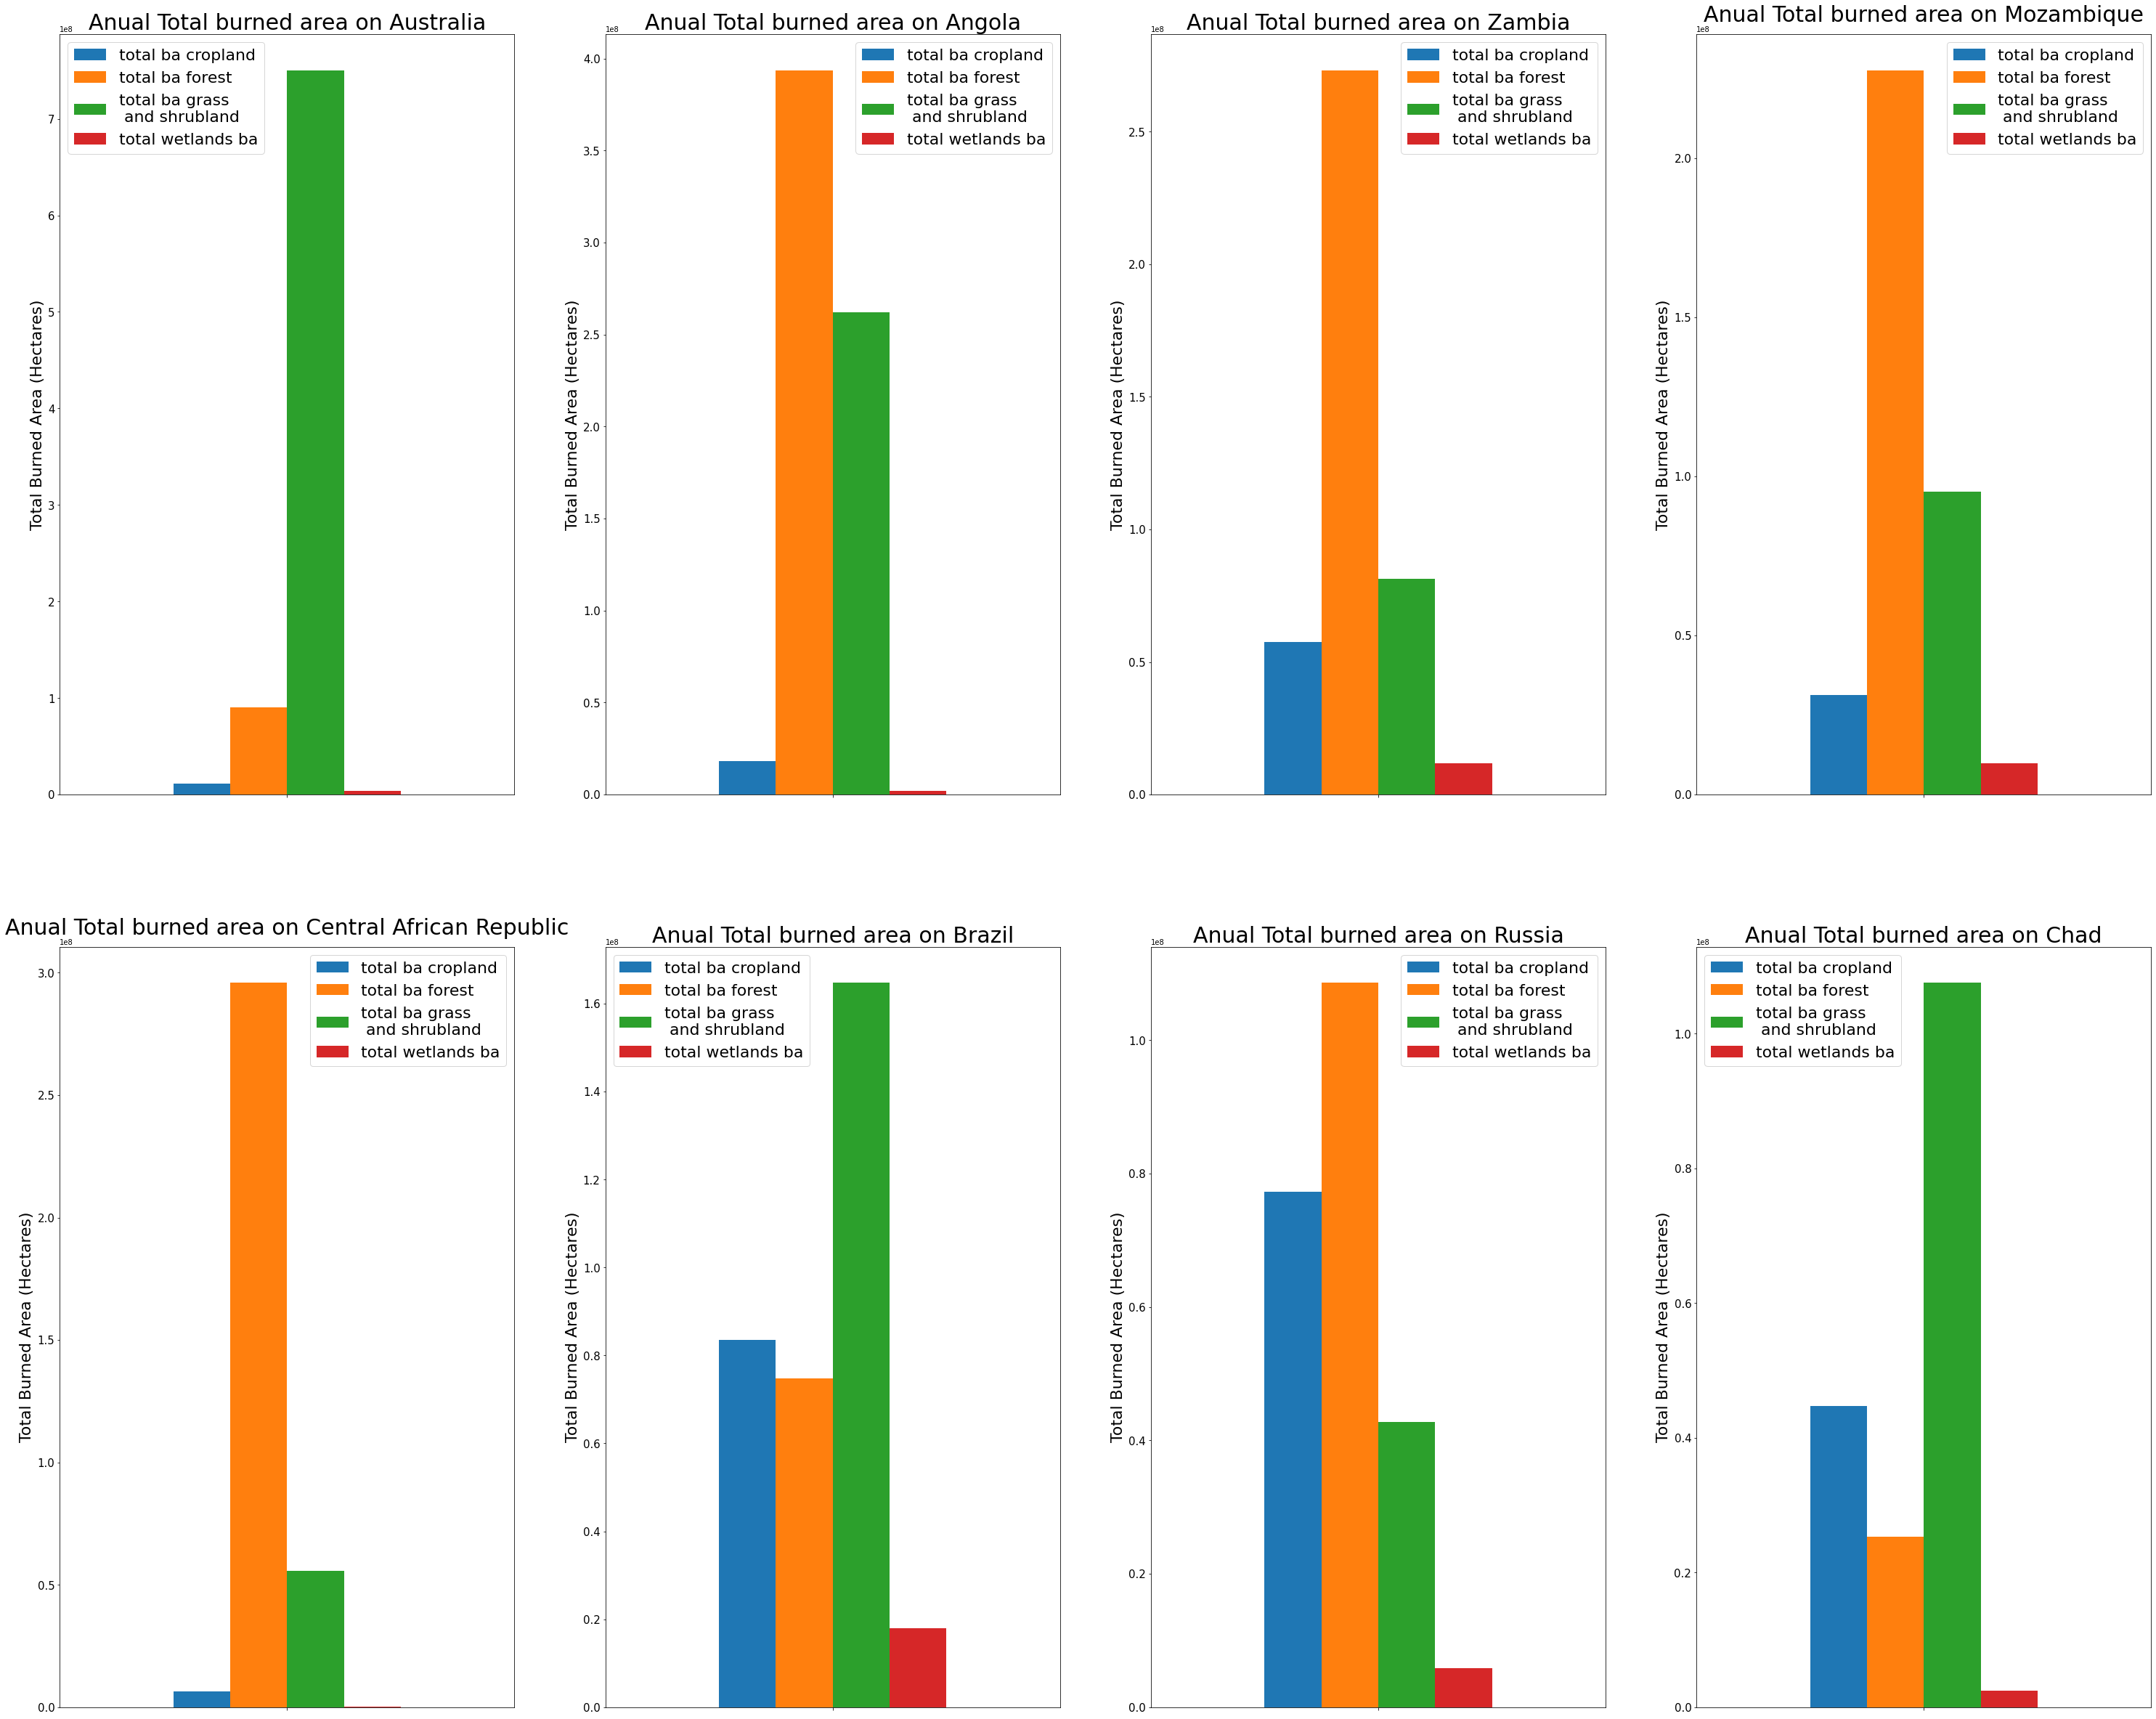

In [29]:
fig, axs = plt.subplots(2,4)
axs = [ax for axs_lst in axs for ax in axs_lst]
labelsFontSize = 22
titleFonteSize = 30 
xTicksSpace = 1 
xLabelRotation = 45
ticksFontSize = 15
coverages_ba =['total_cropland_ba', 'total_forest_ba', 'total_grass_and_shrubland_ba','total_wetlands_ba']

for i, COU in  enumerate(top8AffectedCountries_df['country_code'].unique()):
    country = top8AffectedCountries_df['country_name'].unique()[i]
    query=f"""
        WITH totalBurnedArea AS (
            SELECT
                YEAR(date) as year,
                LEFT(region_code, 3) AS country,
                cropland_ba ,forest_ba , grass_and_shrubland_ba , wetlands_ba , settlement_ba , other_ba 
            FROM
                dbo.BurnedAreaEvolution as b
        )

        SELECT
        c.code as country_code, c.name AS country_name,
            SUM(tba.cropland_ba) AS total_cropland_ba,
            SUM(tba.forest_ba) AS total_forest_ba,
            SUM(tba.grass_and_shrubland_ba) AS total_grass_and_shrubland_ba,
            SUM(tba.wetlands_ba) AS total_wetlands_ba
        FROM
            totalBurnedArea AS tba
        INNER JOIN
            country AS c
        ON
            tba.country = c.code
        WHERE 
            c.code = '{COU}'
        GROUP BY
            c.code,c.name ;
    """
    countryAnualAcumulatedBA_df =  pd.read_sql(query, cnxn)


    #plot
    ax = countryAnualAcumulatedBA_df[coverages_ba].plot(kind= 'bar', ax=axs[i], figsize= (45,10))
    ax.legend(['total ba cropland', 'total ba forest', 'total ba grass \n and shrubland', 'total wetlands ba'],fontsize=labelsFontSize)
    # Add labels and title
    axs[i].set_xlabel('', fontsize=labelsFontSize, labelpad=10)
    axs[i].set_ylabel('Total Burned Area (Hectares)', fontsize=labelsFontSize)
    axs[i].set_title(f'Anual Total burned area on {country}', fontsize=titleFonteSize)

    # Set the x-axis tick labels
    xticks = ''
    axs[i].set_xticklabels(xticks, rotation=xLabelRotation)


    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)
    plt.subplots_adjust(left=0.1, right=0.9, top=2, bottom=0.4)

#savefig
fig.set_size_inches(50, 20)
fig.savefig(IMAGES_PATH + 'ba_coverage_top8_countries.png', dpi=300, bbox_inches='tight')



Ao avaliar avaliar o perfil das queimadas nos topo 8 mais afetados, percebe-se que as localidades mais afeta são ou a com cobertura vegetal ou com cobertura de gramínias e arbustos. Em especial chama a atenção ao fato de no Brasil não se ter  como area afetas areás florestais como amazônio tal como notíciado, mas o cerrado e o pantanal como indicam os dados pois sabe-se que aréas caracterizadas por cobertura de gramíneas e arbustos são ou o cerrado, caating  ou os pampas na região sul, como na região sul não é comum se ter queiamadas então logo deduz-se que  as áreas mais afetas no brasil são as areas uqe possuem cobertura pela caatinga e o cerrado. A mesma tendencia se repete para Australia o pais mais afetado. Quanto ao s demais as areas mais afetadas são regiões de floresta.

## **Impactos econômicas e peradas Humanas decorrentes das queimadas**

Na análise anterior foi feita uma análise de intensidade das queimadas considerando que a intensidade das queimadas está intrinsicamente ligada a quantidade de área queimada pelo fogo, e não se percebeu-se por essa linha de análise algum tipo de mudança significativa com o passar dos anos. Entretanto, não foi analisado anteriormente o impacto humanidade. Nesse sentido aqui vamos avaliar tais impactos em termos de peradas econômica e de humanas focada, ou seja, em qual foi o prejuízo causado pelas queimadas e o número de mortes a ela associado.

Primeiramente vamos analisar globalmente a evolução da s perdas econômicas e humanas anuais de acordo com a abrangência dos dados disponíveis:

In [ ]:
fig, axs = plt.subplots(2,1)

labelsFontSize = 30
titleFonteSize = 50 
xTicksSpace = 1 
xLabelRotation = 45
ticksFontSize = 30
vars = ['total_damage', 'total_deaths']
titles = ['Anual impact due wildfires - Ecominic Damages', 'Anual impact due wildfires - Deaths']
yLabels = [ 'Total damages  (1K USD)', 'Total Deaths']
for i, COU in  enumerate(vars):
    query=f"""
        SELECT
            YEAR(date) as year,
            SUM(total_damage) AS total_damage,
            SUM(total_deaths) AS total_deaths
        FROM 
            EconomicLifeLosses 
        WHERE 
            disaster_type = 'Wildfire'
        GROUP BY YEAR(date);
    """
    anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)


    #plot
    anutalTotalLifeAndLosses[vars[i]].plot(kind= 'bar', ax=axs[i], figsize= (35,10))

    # Add labels and title
    axs[i].set_xlabel('', fontsize=labelsFontSize, labelpad=10)
    axs[i].set_ylabel(yLabels[i], fontsize=labelsFontSize)
    axs[i].set_title(titles[i], fontsize=titleFonteSize)

    # Set the x-axis tick labels
    xticks = list(anutalTotalLifeAndLosses['year'])
    axs[i].set_xticklabels(xticks, rotation=xLabelRotation)

    tick_positions = range(0, len(xticks), xTicksSpace)  # Increase space every 5 ticks, you can adjust this value
    tick_labels = [xticks[i] for i in tick_positions]

    # Set the x-axis tick positions and labels
    axs[i].set_xticks(tick_positions)
    axs[i].set_xticklabels(tick_labels, rotation=xLabelRotation)
    axs[i].set_xticklabels(tick_labels, rotation=xLabelRotation)

    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)
    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)
    plt.subplots_adjust(left=0.1, right=0.9, top=2, bottom=0.4)


#savings subplots
fig.set_size_inches(50, 20)
fig.savefig(IMAGES_PATH + 'economic_and_life_losses.png', dpi=300, bbox_inches='tight')

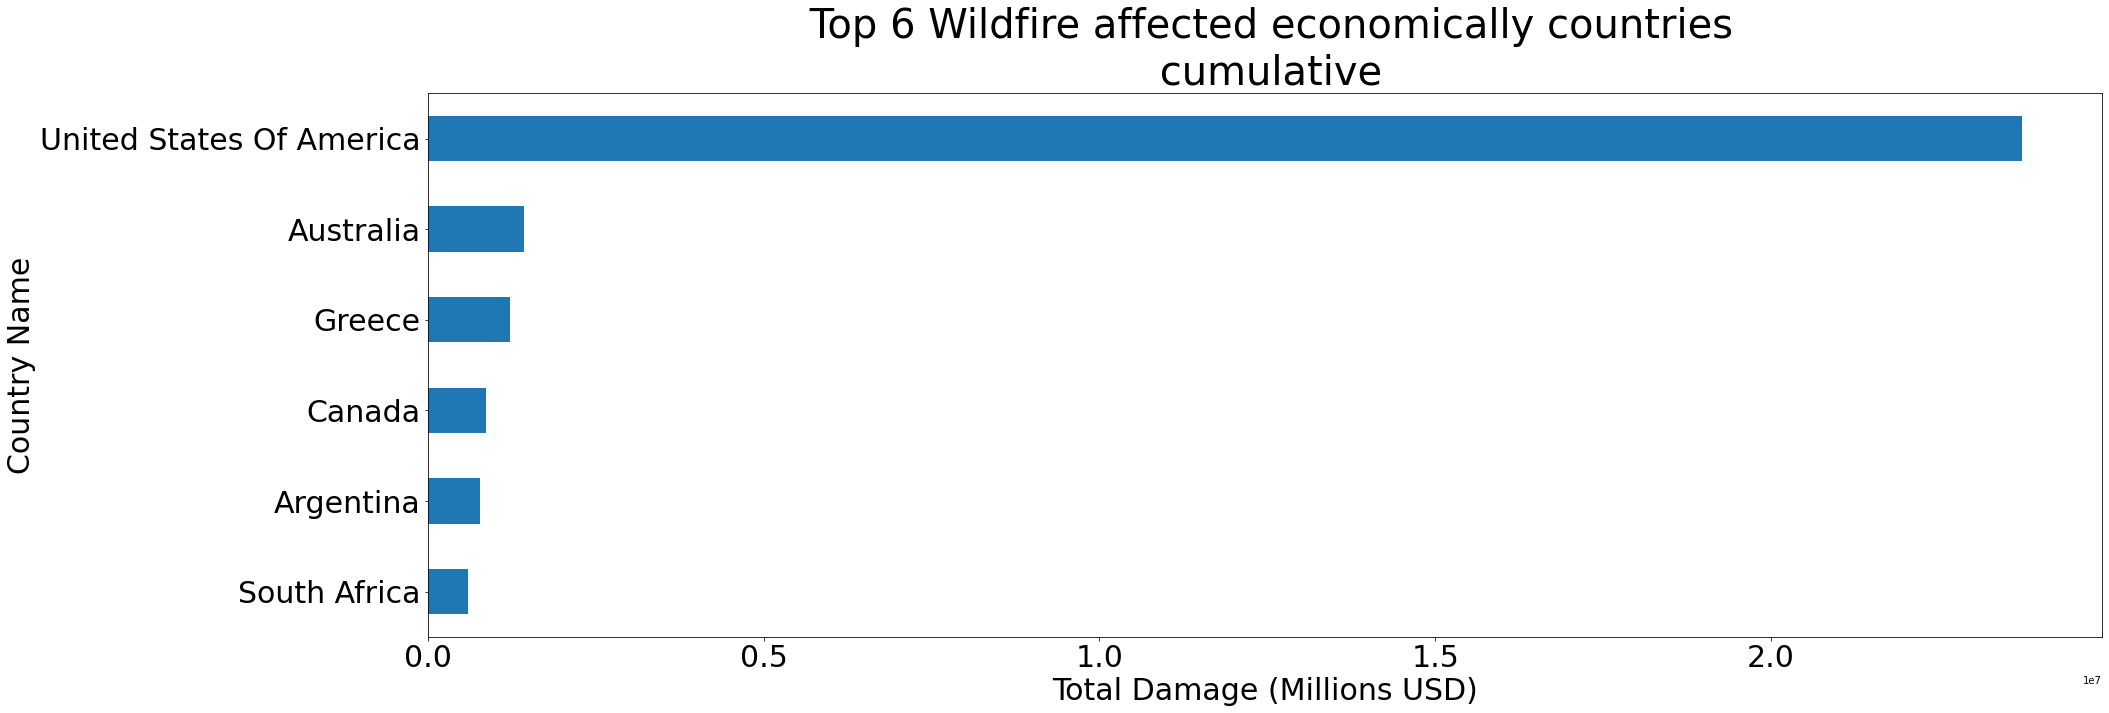

In [9]:
    query=f"""
        SELECT  TOP 6
            ell.country_code,
            c.name AS country_name,
            SUM(total_damage) AS total_damage

        FROM 
            EconomicLifeLosses AS ell
        INNER JOIN
            dbo.country AS c
        ON
            ell.country_code = c.code
        WHERE
            disaster_type='Wildfire'
        GROUP BY
            ell.country_code,c.name
        ORDER BY
            total_damage DESC;
    """
anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)
plot_dfChart(anutalTotalLifeAndLosses.sort_values(by='total_damage'), 'country_name', 'total_damage', figsize=(30,10), title=" Top 6 Wildfire affected economically countries\n cumulative", xLabel='Country Name', yLabel='Total Damage (Millions USD)', chart_type='barh', xLabelRotation=0, ticksFontSize=30)
fig.set_size_inches(50, 20)
plt.savefig(IMAGES_PATH + 'top_6_most_economically_affected_countries.png')

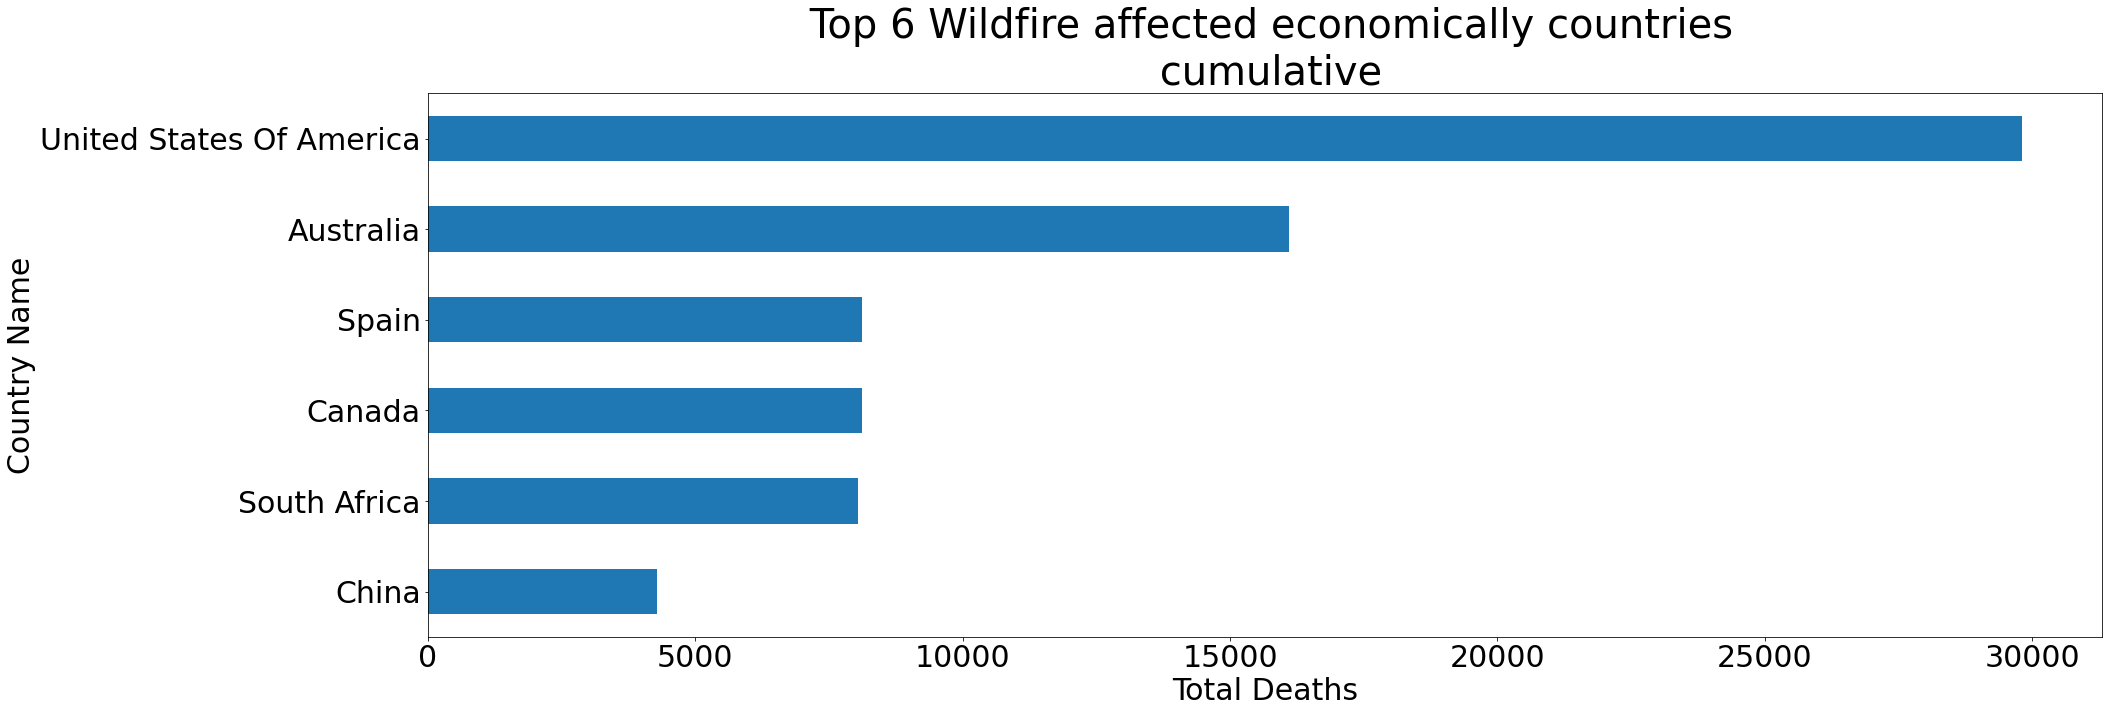

In [10]:
    query=f"""
        SELECT  TOP 6
            ell.country_code,
            c.name AS country_name,
            SUM(total_deaths) AS total_deaths

        FROM 
            EconomicLifeLosses AS ell
        INNER JOIN
            dbo.country AS c
        ON
            ell.country_code = c.code
        WHERE
            disaster_type='Wildfire'
        GROUP BY
            ell.country_code,c.name
        ORDER BY
            total_deaths DESC;
    """
anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)
plot_dfChart(anutalTotalLifeAndLosses.sort_values(by='total_deaths'), 'country_name', 'total_deaths', figsize=(30,10), title=" Top 6 Wildfire affected economically countries\n cumulative", xLabel='Country Name', yLabel='Total Deaths', chart_type='barh', xLabelRotation=0, ticksFontSize=30)
fig.set_size_inches(50, 20)
plt.savefig(IMAGES_PATH + 'top_6_most_ehumanly_affected_countries.png')

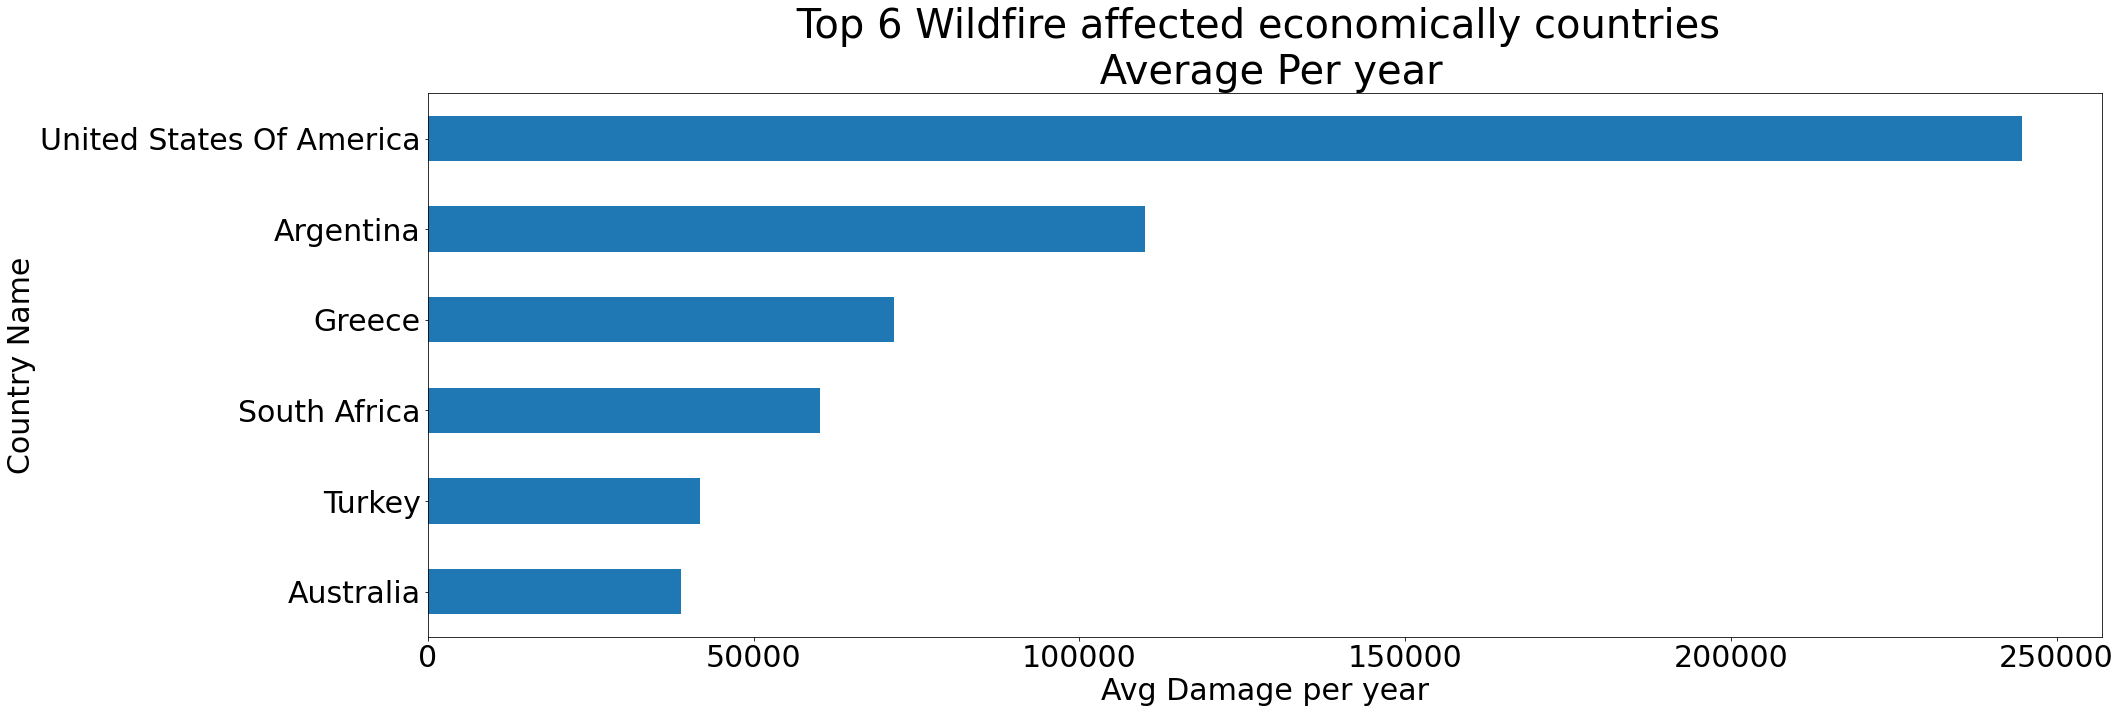

In [11]:
    query=f"""
        SELECT  TOP 6
            ell.country_code,
            c.name AS country_name,
            avg(total_damage) AS avg_damage_year

        FROM 
            EconomicLifeLosses AS ell
        INNER JOIN
            dbo.country AS c
        ON
            ell.country_code = c.code
        WHERE
            disaster_type='Wildfire'
        GROUP BY
            ell.country_code,c.name
        ORDER BY
            avg_damage_year DESC;
    """
anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)
plot_dfChart(anutalTotalLifeAndLosses.sort_values(by='avg_damage_year'), 'country_name', 'avg_damage_year', figsize=(30,10), title=" Top 6 Wildfire affected economically countries  \n Average Per year", xLabel='Country Name', yLabel='Avg Damage per year', chart_type='barh', xLabelRotation=0, ticksFontSize=30)
fig.set_size_inches(50, 20)
plt.savefig(IMAGES_PATH + 'top_6_most_ehumanly_affected_countries.png')

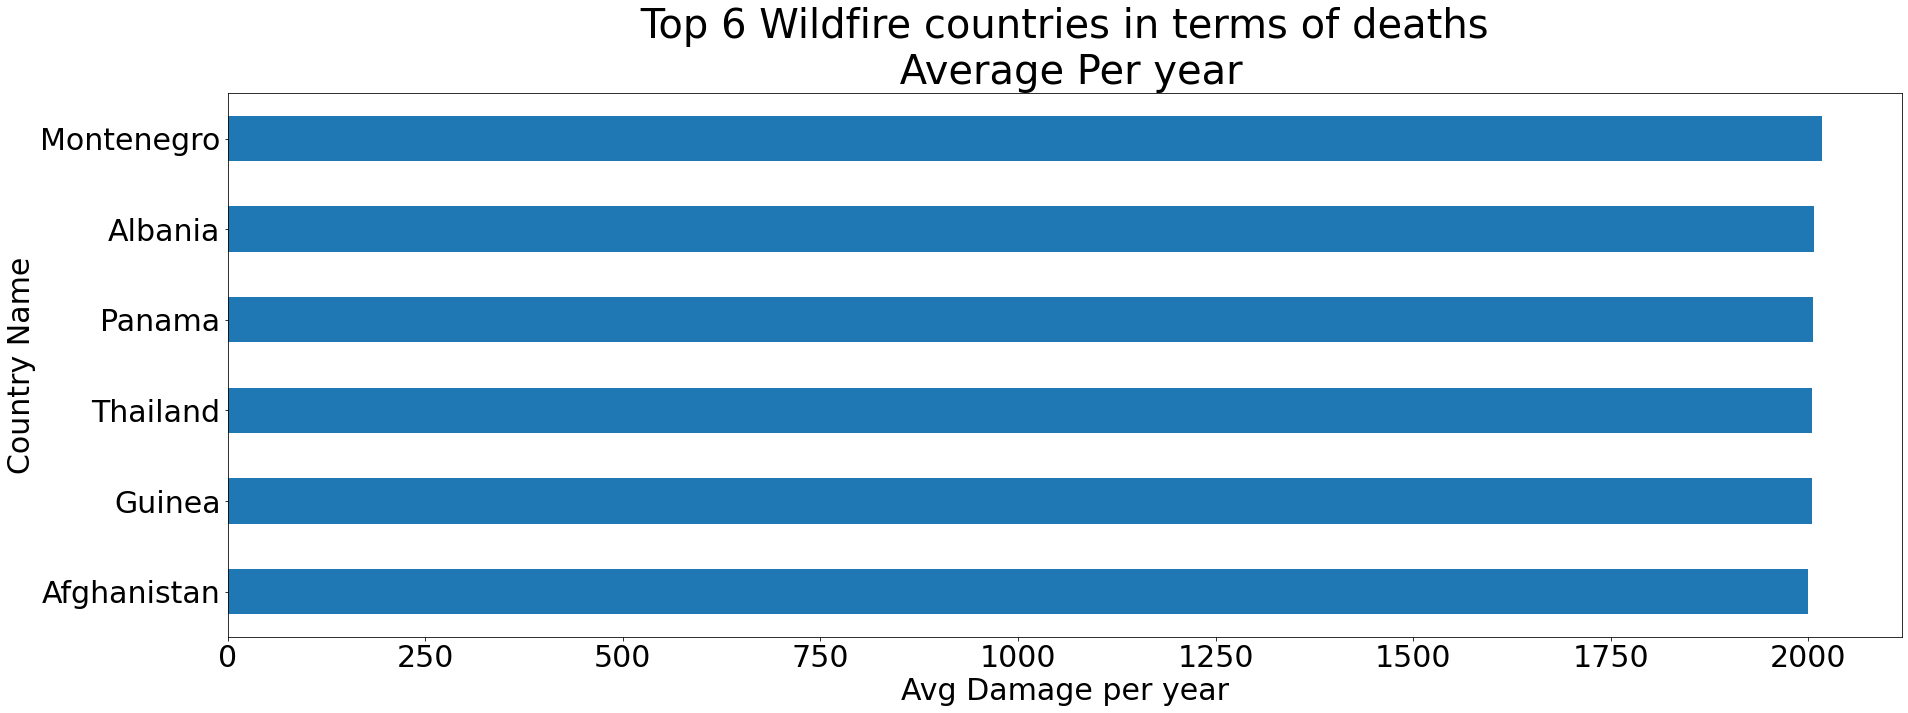

In [12]:
    query=f"""
        SELECT  TOP 6
            ell.country_code,
            c.name AS country_name,
            avg(total_deaths) AS avg_deaths_year

        FROM 
            EconomicLifeLosses AS ell
        INNER JOIN
            dbo.country AS c
        ON
            ell.country_code = c.code
        WHERE
            disaster_type='Wildfire'
        GROUP BY
            ell.country_code,c.name
        ORDER BY
            avg_deaths_year DESC;
    """
anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)
plot_dfChart(anutalTotalLifeAndLosses.sort_values(by='avg_deaths_year'), 'country_name', 'avg_deaths_year', figsize=(30,10), title=" Top 6 Wildfire countries in terms of deaths \n Average Per year", xLabel='Country Name', yLabel='Avg Damage per year', chart_type='barh', xLabelRotation=0, ticksFontSize=30)
fig.set_size_inches(50, 20)
plt.savefig(IMAGES_PATH + 'top_6_most_ehumanly_affected_countries.png')

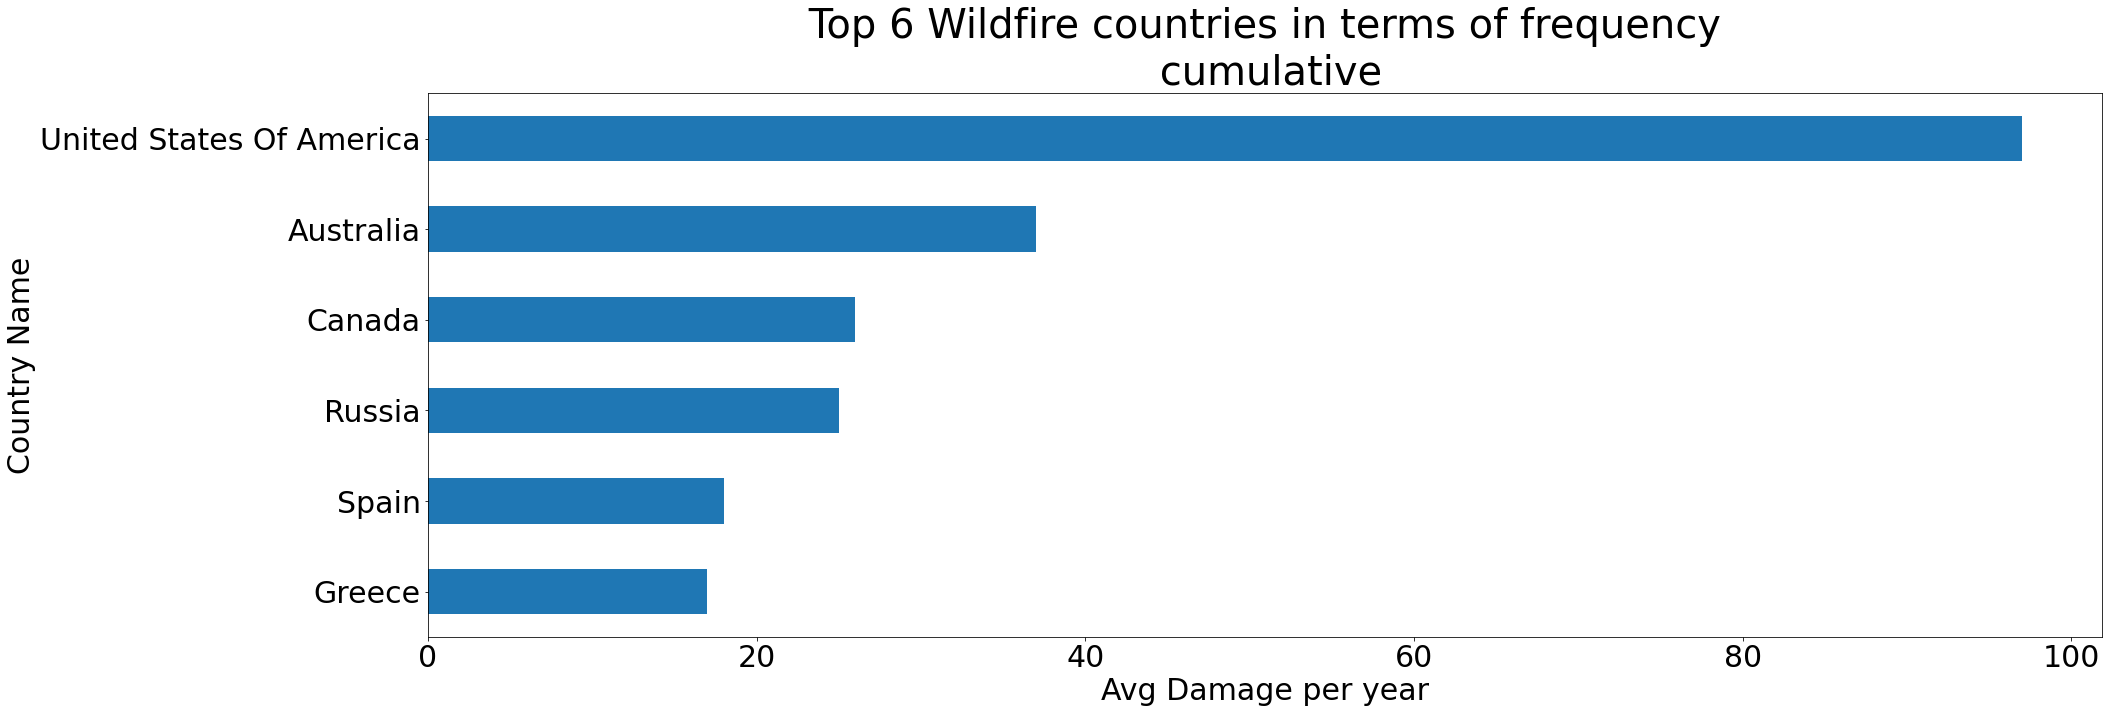

In [13]:
    query=f"""
SELECT  TOP 6
    ell.country_code,
    c.name AS country_name,
    count(*) as frequency

FROM 
    EconomicLifeLosses AS ell
INNER JOIN
    dbo.country AS c
ON
    ell.country_code = c.code
WHERE
    disaster_type='Wildfire'
GROUP BY
    ell.country_code,c.name
ORDER BY
    frequency DESC;
    """
anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)
plot_dfChart(anutalTotalLifeAndLosses.sort_values(by='frequency'), 'country_name', 'frequency', figsize=(30,10), title=" Top 6 Wildfire countries in terms of frequency \n cumulative", xLabel='Country Name', yLabel='Avg Damage per year', chart_type='barh', xLabelRotation=0, ticksFontSize=30)
fig.set_size_inches(50, 20)
plt.savefig(IMAGES_PATH + 'top_6_most_ehumanly_affected_countries.png')

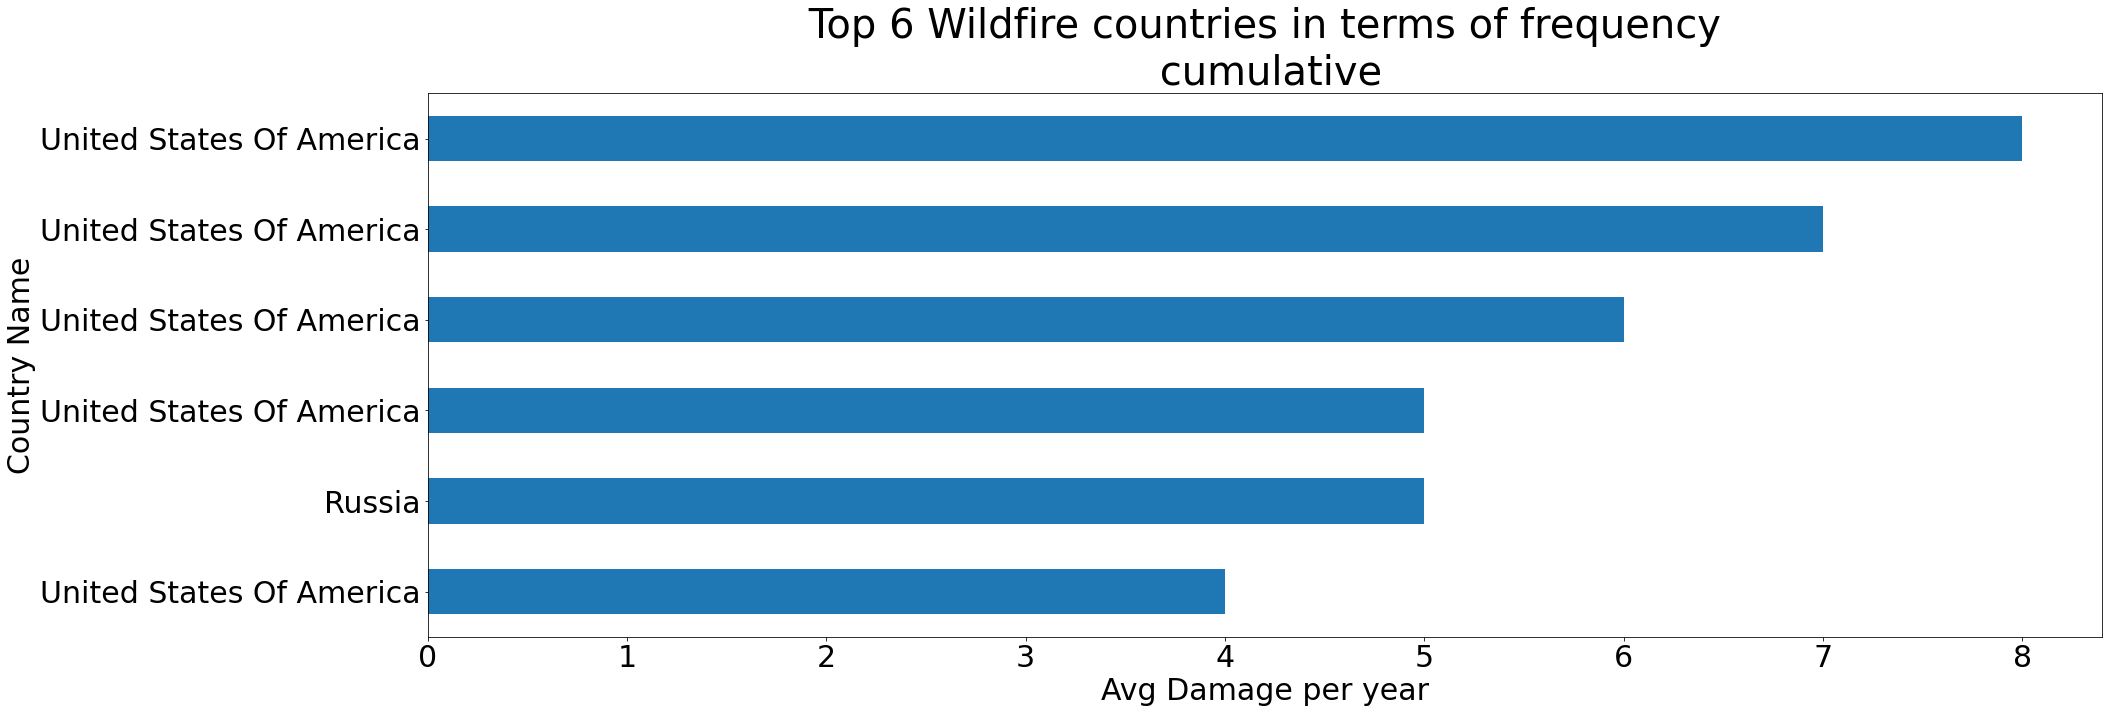

In [14]:
    query=f"""
SELECT  TOP 6
    ell.country_code,
    c.name AS country_name,
    count(*) as frequency

FROM 
    EconomicLifeLosses AS ell
INNER JOIN
    dbo.country AS c
ON
    ell.country_code = c.code
WHERE
    disaster_type='Wildfire'
GROUP BY
    ell.country_code,c.name, ell.date
ORDER BY
    frequency DESC;
    """
anutalTotalLifeAndLosses =  pd.read_sql(query, cnxn)
plot_dfChart(anutalTotalLifeAndLosses.sort_values(by='frequency'), 'country_name', 'frequency', figsize=(30,10), title=" Top 6 Wildfire countries in terms of frequency \n cumulative", xLabel='Country Name', yLabel='Avg Damage per year', chart_type='barh', xLabelRotation=0, ticksFontSize=30)
fig.set_size_inches(50, 20)
plt.savefig(IMAGES_PATH + 'top_6_most_ehumanly_affected_countries.png')

C:\Users\lucas\AppData\Local\Temp/ipykernel_13600/1548385992.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_data['trend_line']  = list(y)
C:\Users\lucas\AppData\Local\Temp/ipykernel_13600/1548385992.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([1949, 1950,1961, 1972, 1983, 1994, 2005, 2016,2022, 2023], rotation=xLabelRotation)
C:\Users\lucas\AppData\Local\Temp/ipykernel_13600/1548385992.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([1995,1998, 2003, 2005, 2009, 2015,2022], rotation=xLabelRotation)


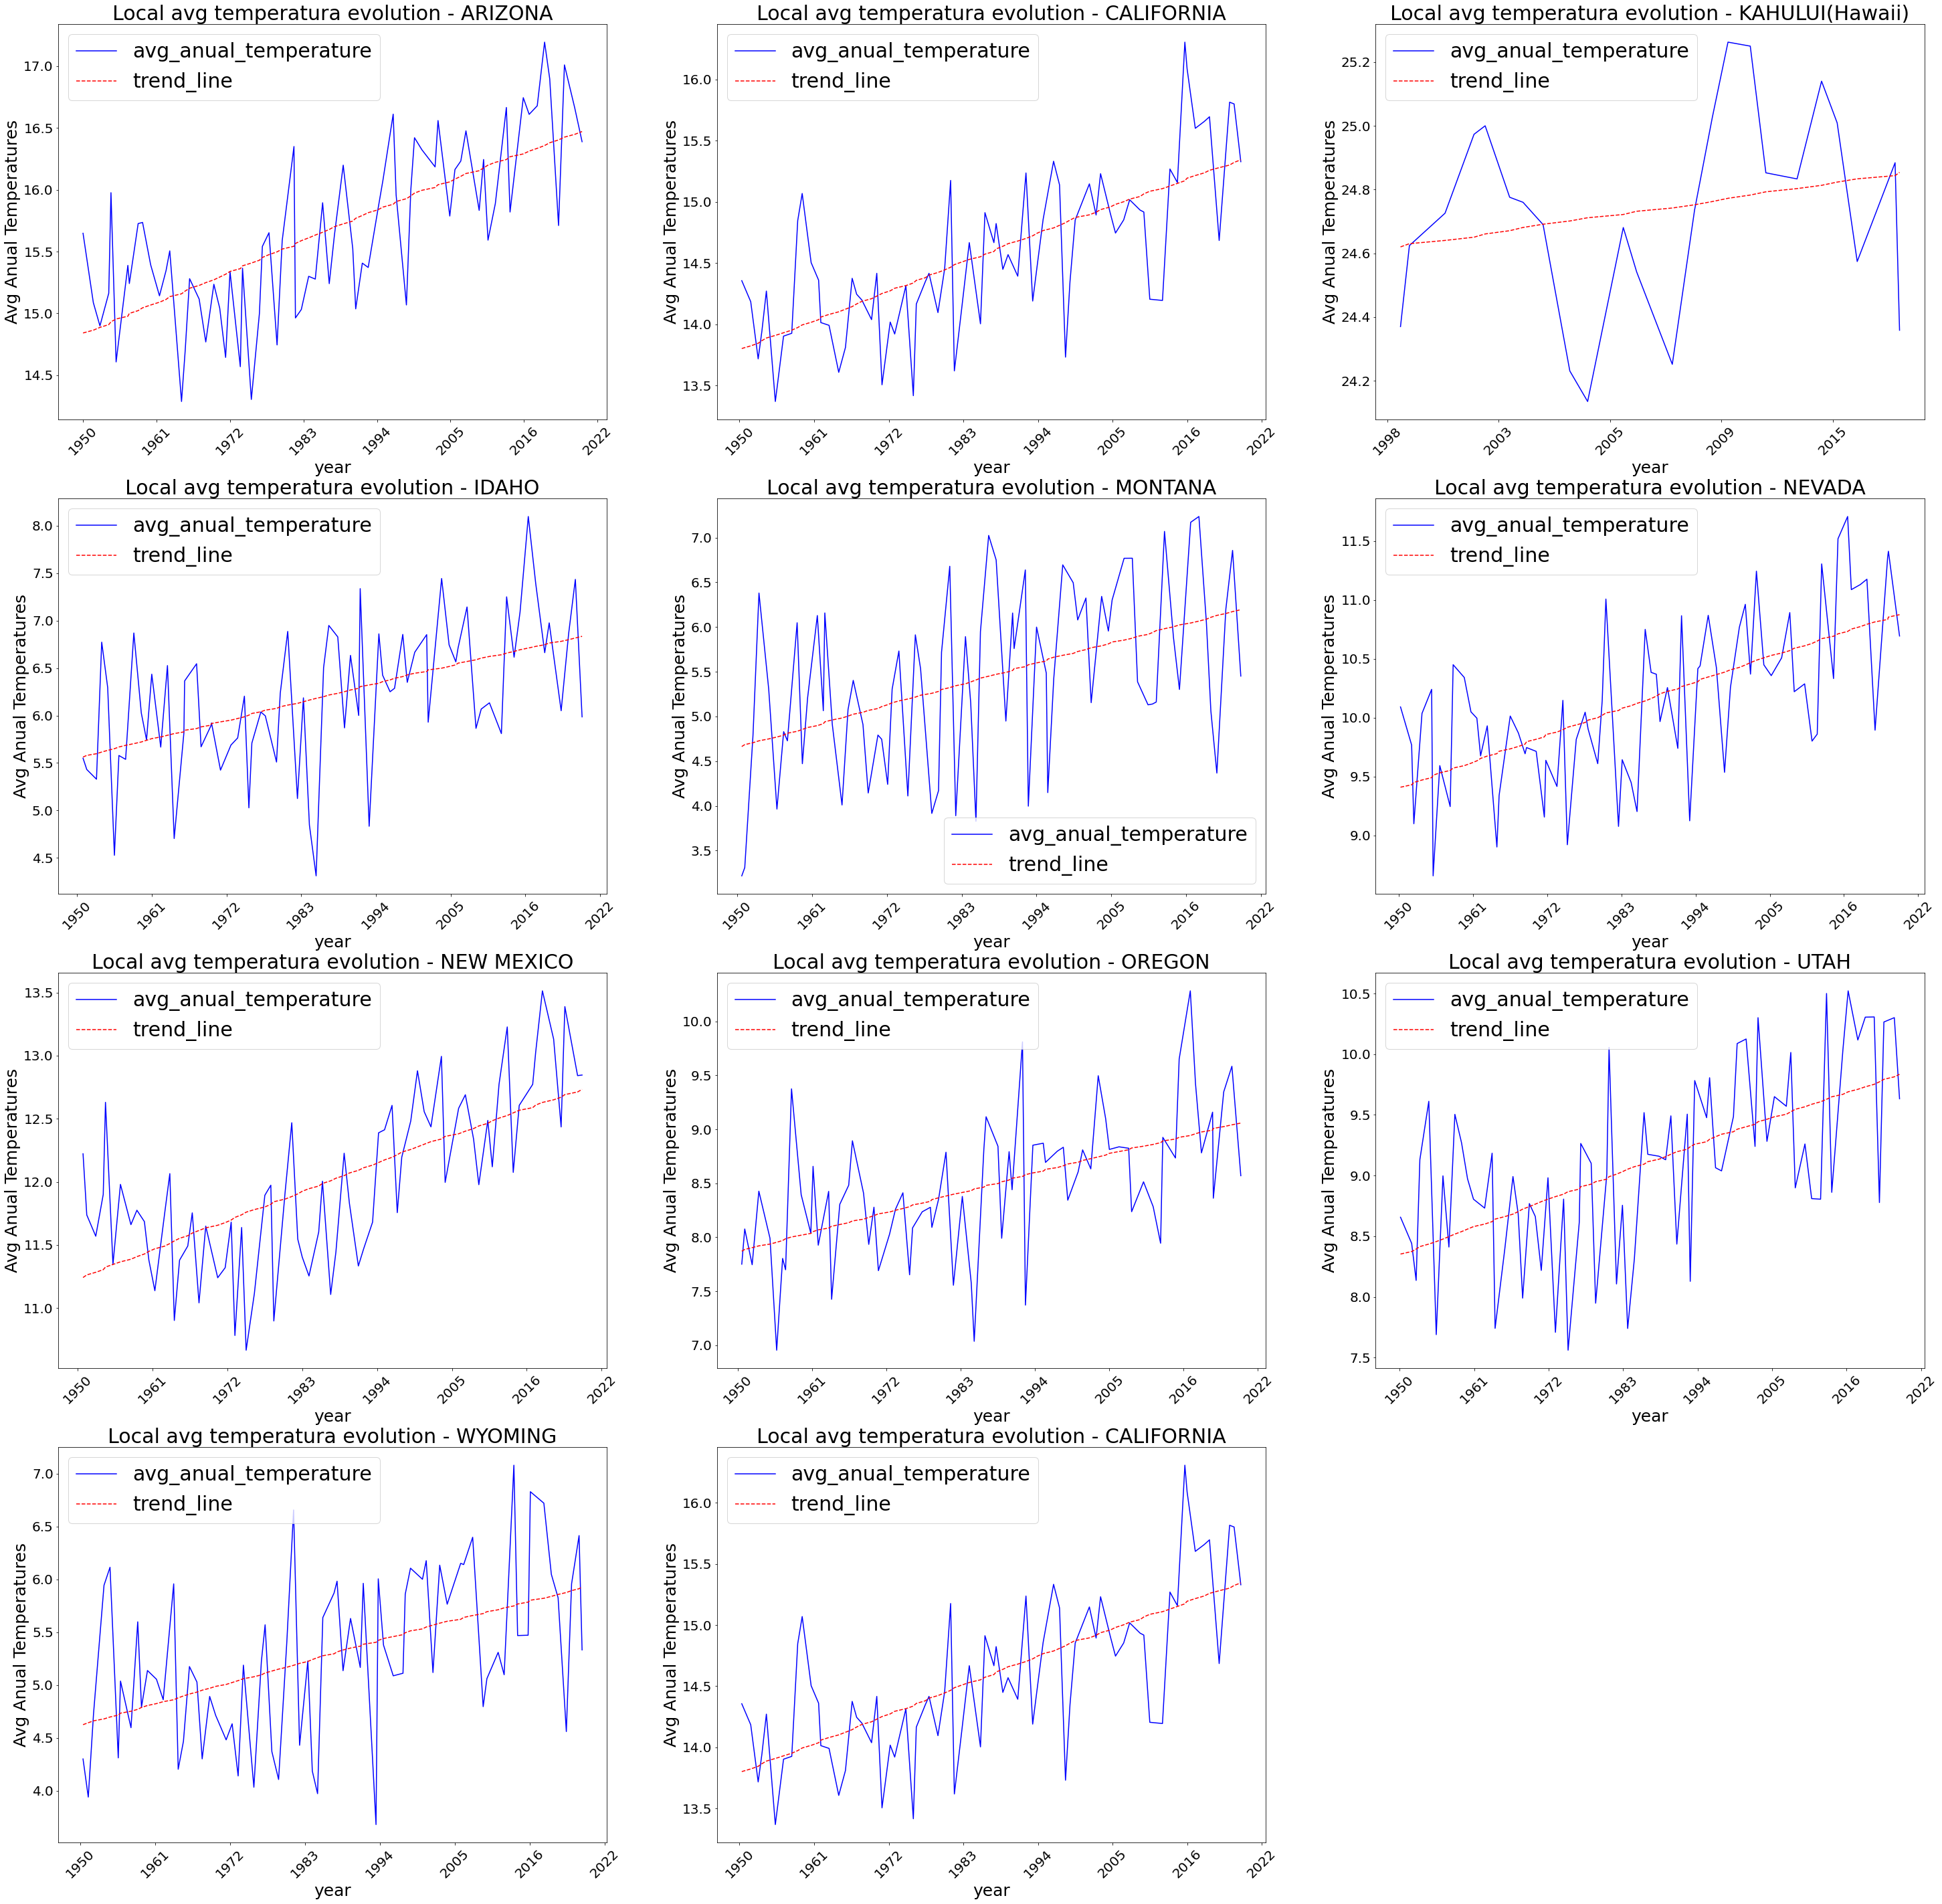

In [15]:

from scipy.stats import linregress
import numpy as np 
figsize = (40, 60)
labelsFontSize = 25
titleFonteSize = 30
xVar = 'year'
xTicksSpace = 1
xLabelRotation = 45
ticksFontSize= 20
yVar = 'avg_anual_temperature'
chart_type = 'line'
US_west_states= [  'Arizona', 'California', 'Kahului', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah','Wyoming', 'California']
xLabel = 'year'
yLabel = 'Avg Anual Temperatures'

fig, axs = plt.subplots(4,3, figsize=figsize)
axs = [ax for axs_lst in axs for ax in axs_lst]

query=f"""
with aux_loc AS( 
    SELECT 
        YEAR(lat.date) as year,
        l.name,
        lat.type as location_type,
        lat.avg_temperature
    FROM
        LocalAvgTemperatures lat

    INNER JOIN
        staging.locations l
    ON
        lat.location_id = l.id
    
)
SELECT   
    year, name,  avg(avg_temperature)   as avg_anual_temperature
FROM
    aux_loc 
WHERE 
    name IN(
        'Arizona', 'California', 'Kahului', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah','Wyoming','California' --WEST USA
        )
 GROUP BY 
    name, year 
 ORDER BY
    year asc
 ;
    """
LocalAvgAnualTemperatures =  pd.read_sql(query, cnxn)

for i,state in  enumerate(US_west_states): 

   
    title  =  'Local avg temperatura evolution - ' + state.upper()
    # Read the CSV file into a DataFrame
    local_data = LocalAvgAnualTemperatures[LocalAvgAnualTemperatures['name'] == state]

    #calculate trend_line
    slope, intercept, _, _, _ = linregress(local_data[xVar], local_data[yVar])
    y= intercept + slope * local_data[xVar]
    local_data['trend_line']  = list(y)
    
    
    # Create the bar chart using the DataFrame and the specified axis
    local_data[[yVar, 'trend_line']].plot(kind= chart_type, ax=axs[i], label=state.upper(), figsize=(20,20), style=['b', 'r--'])

    #set labels and title
    axs[i].set_xlabel(xLabel, fontsize=labelsFontSize)
    axs[i].set_ylabel(yLabel, fontsize=labelsFontSize)
    axs[i].set_title(title, fontsize=titleFonteSize)

    # Set the x-axis tick labels
    xticks = list(local_data[xVar])
    tick_positions = range(0, len(xticks), xTicksSpace)  
    tick_labels = [xticks[i] for i in tick_positions]
    #axs[i].set_xticks(tick_positions)

    max_year = 2022
    min_year = 1950
    step = int((max_year  - min_year)/6.6)
    axs[i].set_xticklabels([1949, 1950,1961, 1972, 1983, 1994, 2005, 2016,2022, 2023], rotation=xLabelRotation)


    if  state == 'Kahului':
        axs[i].set_title(title + '(Hawaii)', fontsize=titleFonteSize)
        axs[i].set_xticklabels([1995,1998, 2003, 2005, 2009, 2015,2022], rotation=xLabelRotation)



    # Set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)

    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)

    axs[i].legend(fontsize=30)

fig.delaxes(axs[-1])
#savefig
fig.set_size_inches(50, 50)
fig.savefig(IMAGES_PATH + 'avg_local_temp_west_us_states.png', dpi=300, bbox_inches='tight')

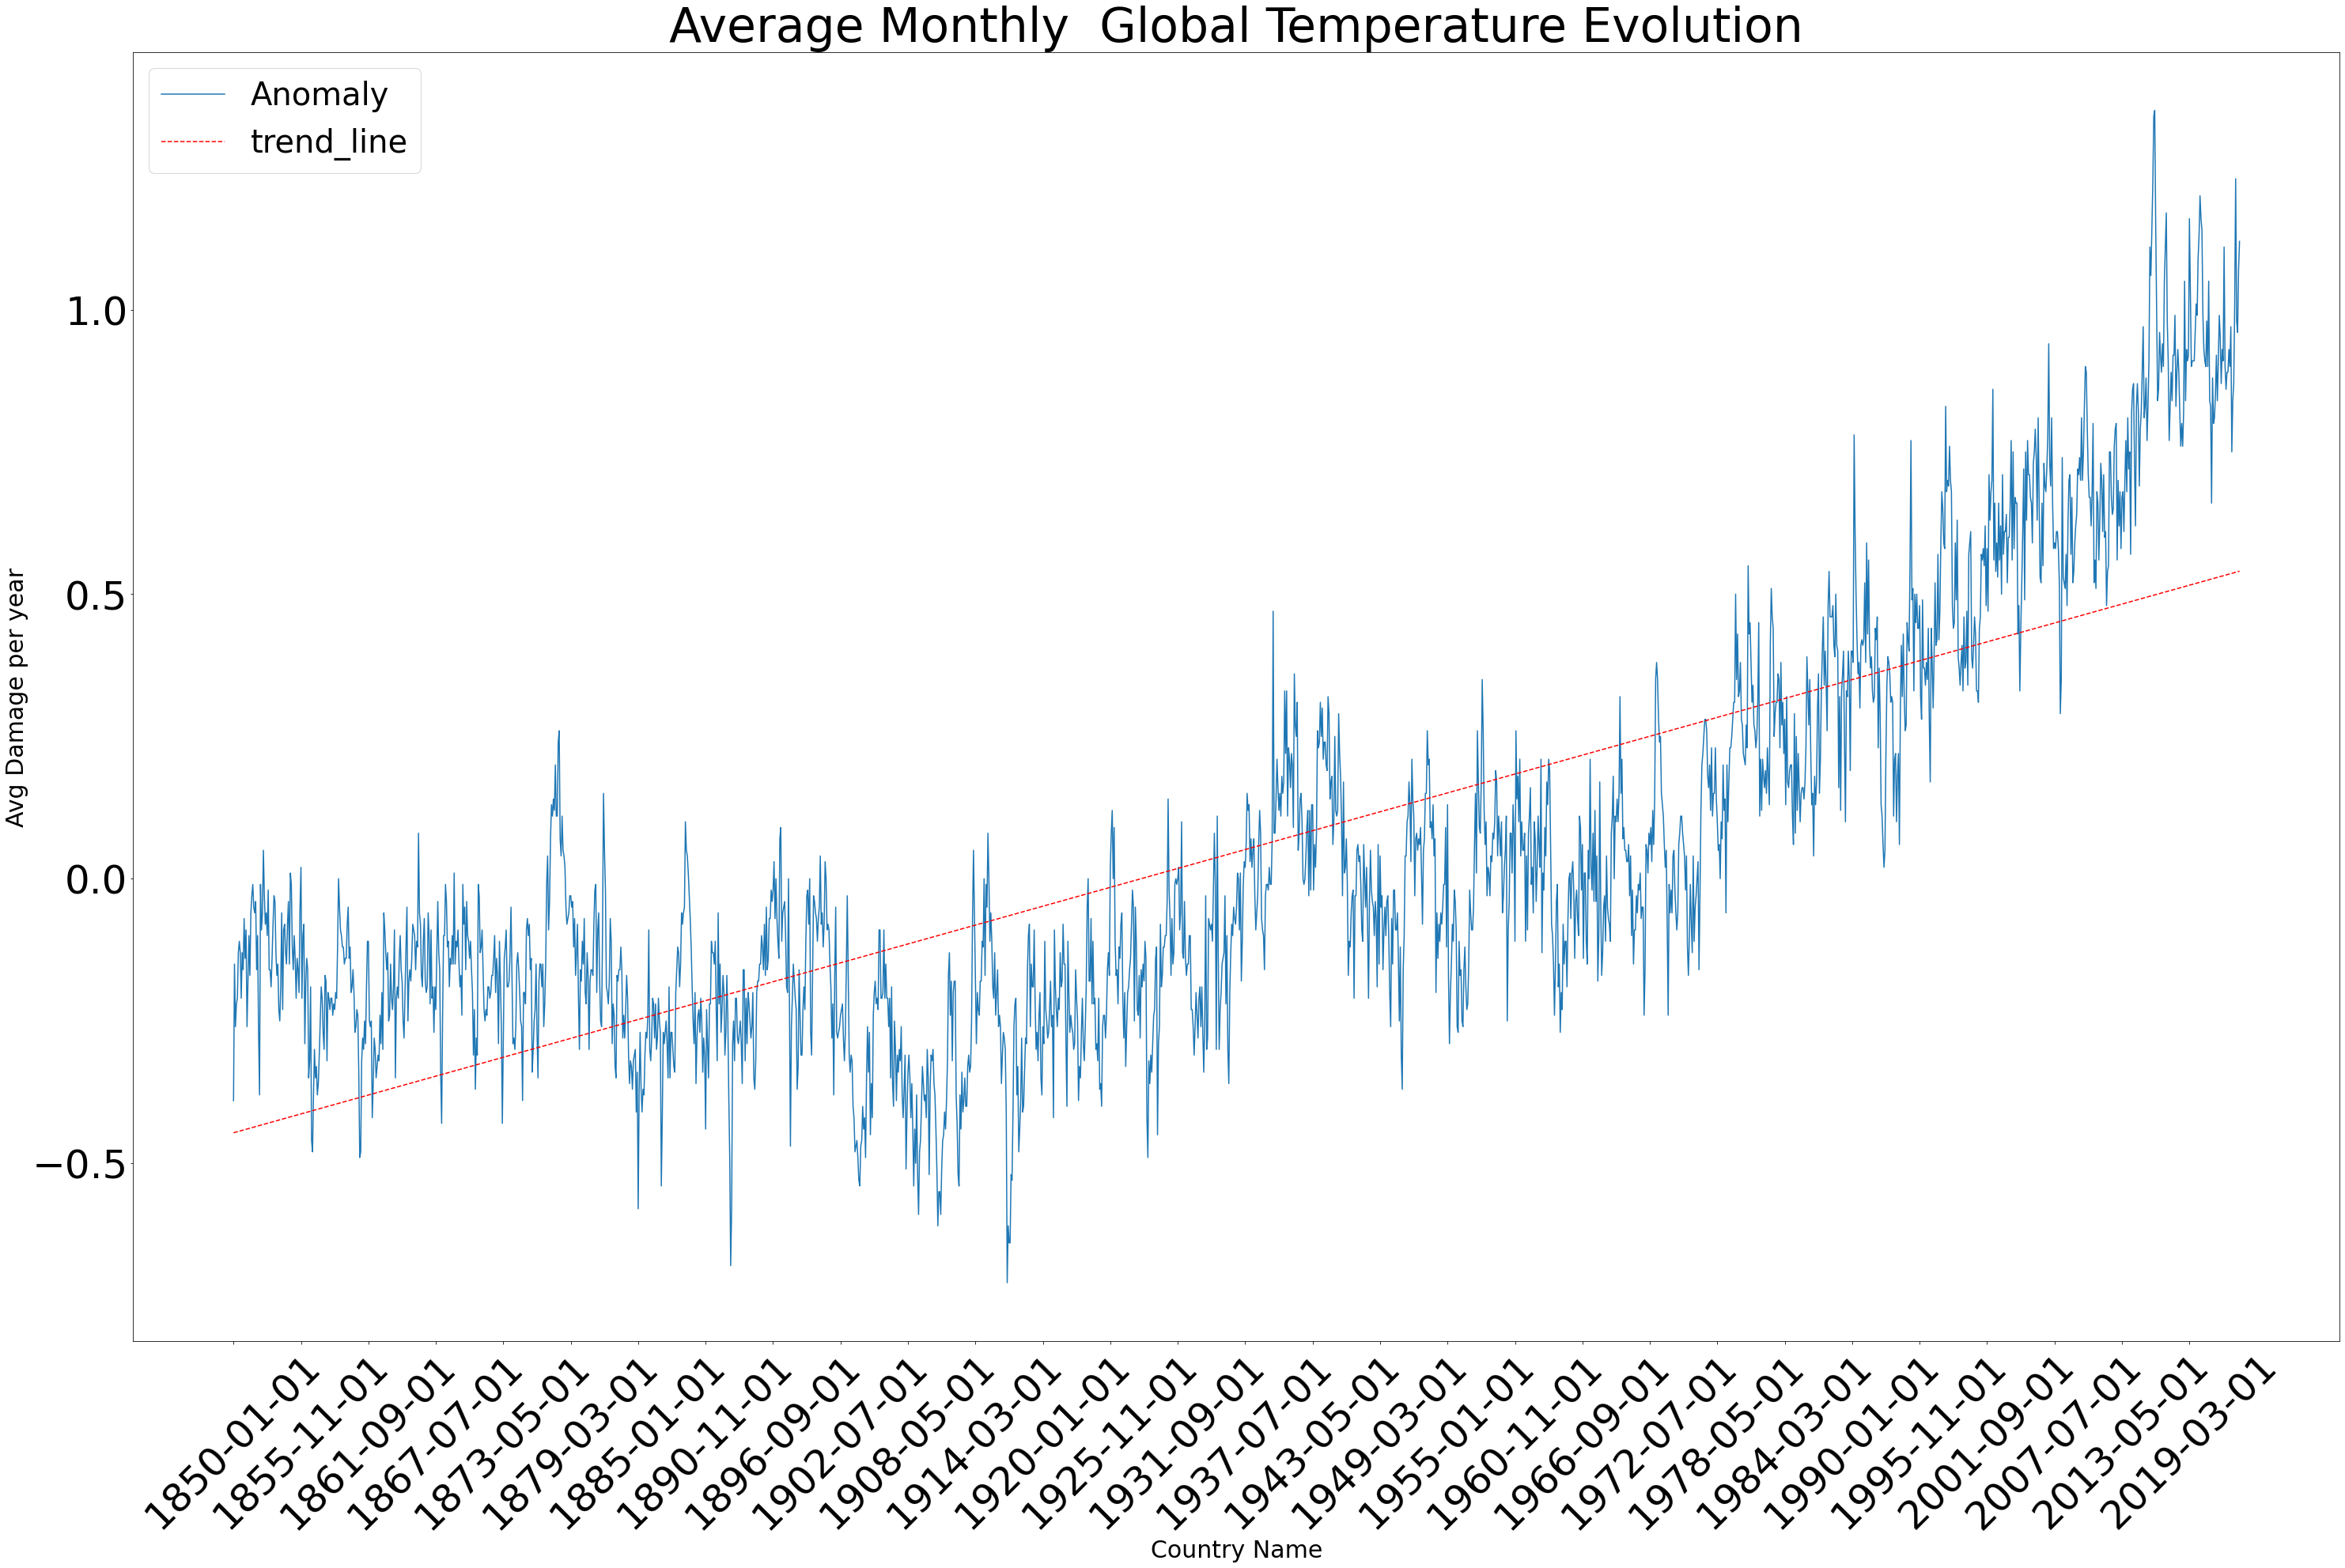

In [16]:
query=f"""
SELECT
     * 
FROM 
    GlobalAnomalyTemperatures 
WHERE 
    coverage='land and sea' 
ORDER BY 
    date;
    """
globalAnomalyTemperatures =  pd.read_sql(query, cnxn)
fig, ax  = plot_dfChart(
                globalAnomalyTemperatures, 'date', 'anomaly',
                figsize=(30,10), title=" Average Monthly  Global Temperature Evolution ",
                xLabel='Country Name', yLabel='Avg Damage per year', chart_type='line',
                xLabelRotation=45, ticksFontSize=50, xTicksSpace=70, titleFonteSize=60
             )

#calculate trend_line
x_vals = np.array(range(0,len(globalAnomalyTemperatures['date'].values) ))
slope, intercept, _, _, _ = linregress(x_vals, globalAnomalyTemperatures['anomaly'].values)

x= ax.get_xticks()
y = intercept + slope * x_vals
ax.plot(x_vals,y, 'r--', label= 'trend_line')
ax.legend(['Anomaly','trend_line'], fontsize=40)
fig.set_size_inches(50, 30)
plt.savefig(IMAGES_PATH + 'avgAnomalyTemperatures.png')

In [17]:
import numpy as np
from scipy.interpolate import interp1d

def resample_toSameSize(x,y):# Assuming x and y have different lengths
    len_x = len(x)
    len_y = len(y)
    # Determine the number of points you want in the resampled series (e.g., the smaller of the two lengths)
    num_points = min(len_x, len_y)
    # Create an interpolation function for x
    x_interp_func = interp1d(np.linspace(0, 1, len_x), x, kind='linear', fill_value='extrapolate')
    # Create an interpolation function for y
    y_interp_func = interp1d(np.linspace(0, 1, len_y), y, kind='linear', fill_value='extrapolate')
    # Generate resampled x and y with the same number of points
    x_resampled = x_interp_func(np.linspace(0, 1, num_points))
    y_resampled = y_interp_func(np.linspace(0, 1, num_points))

    return x_resampled, y_resampled

C:\Users\lucas\AppData\Local\Temp/ipykernel_13600/947095862.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(ticks)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


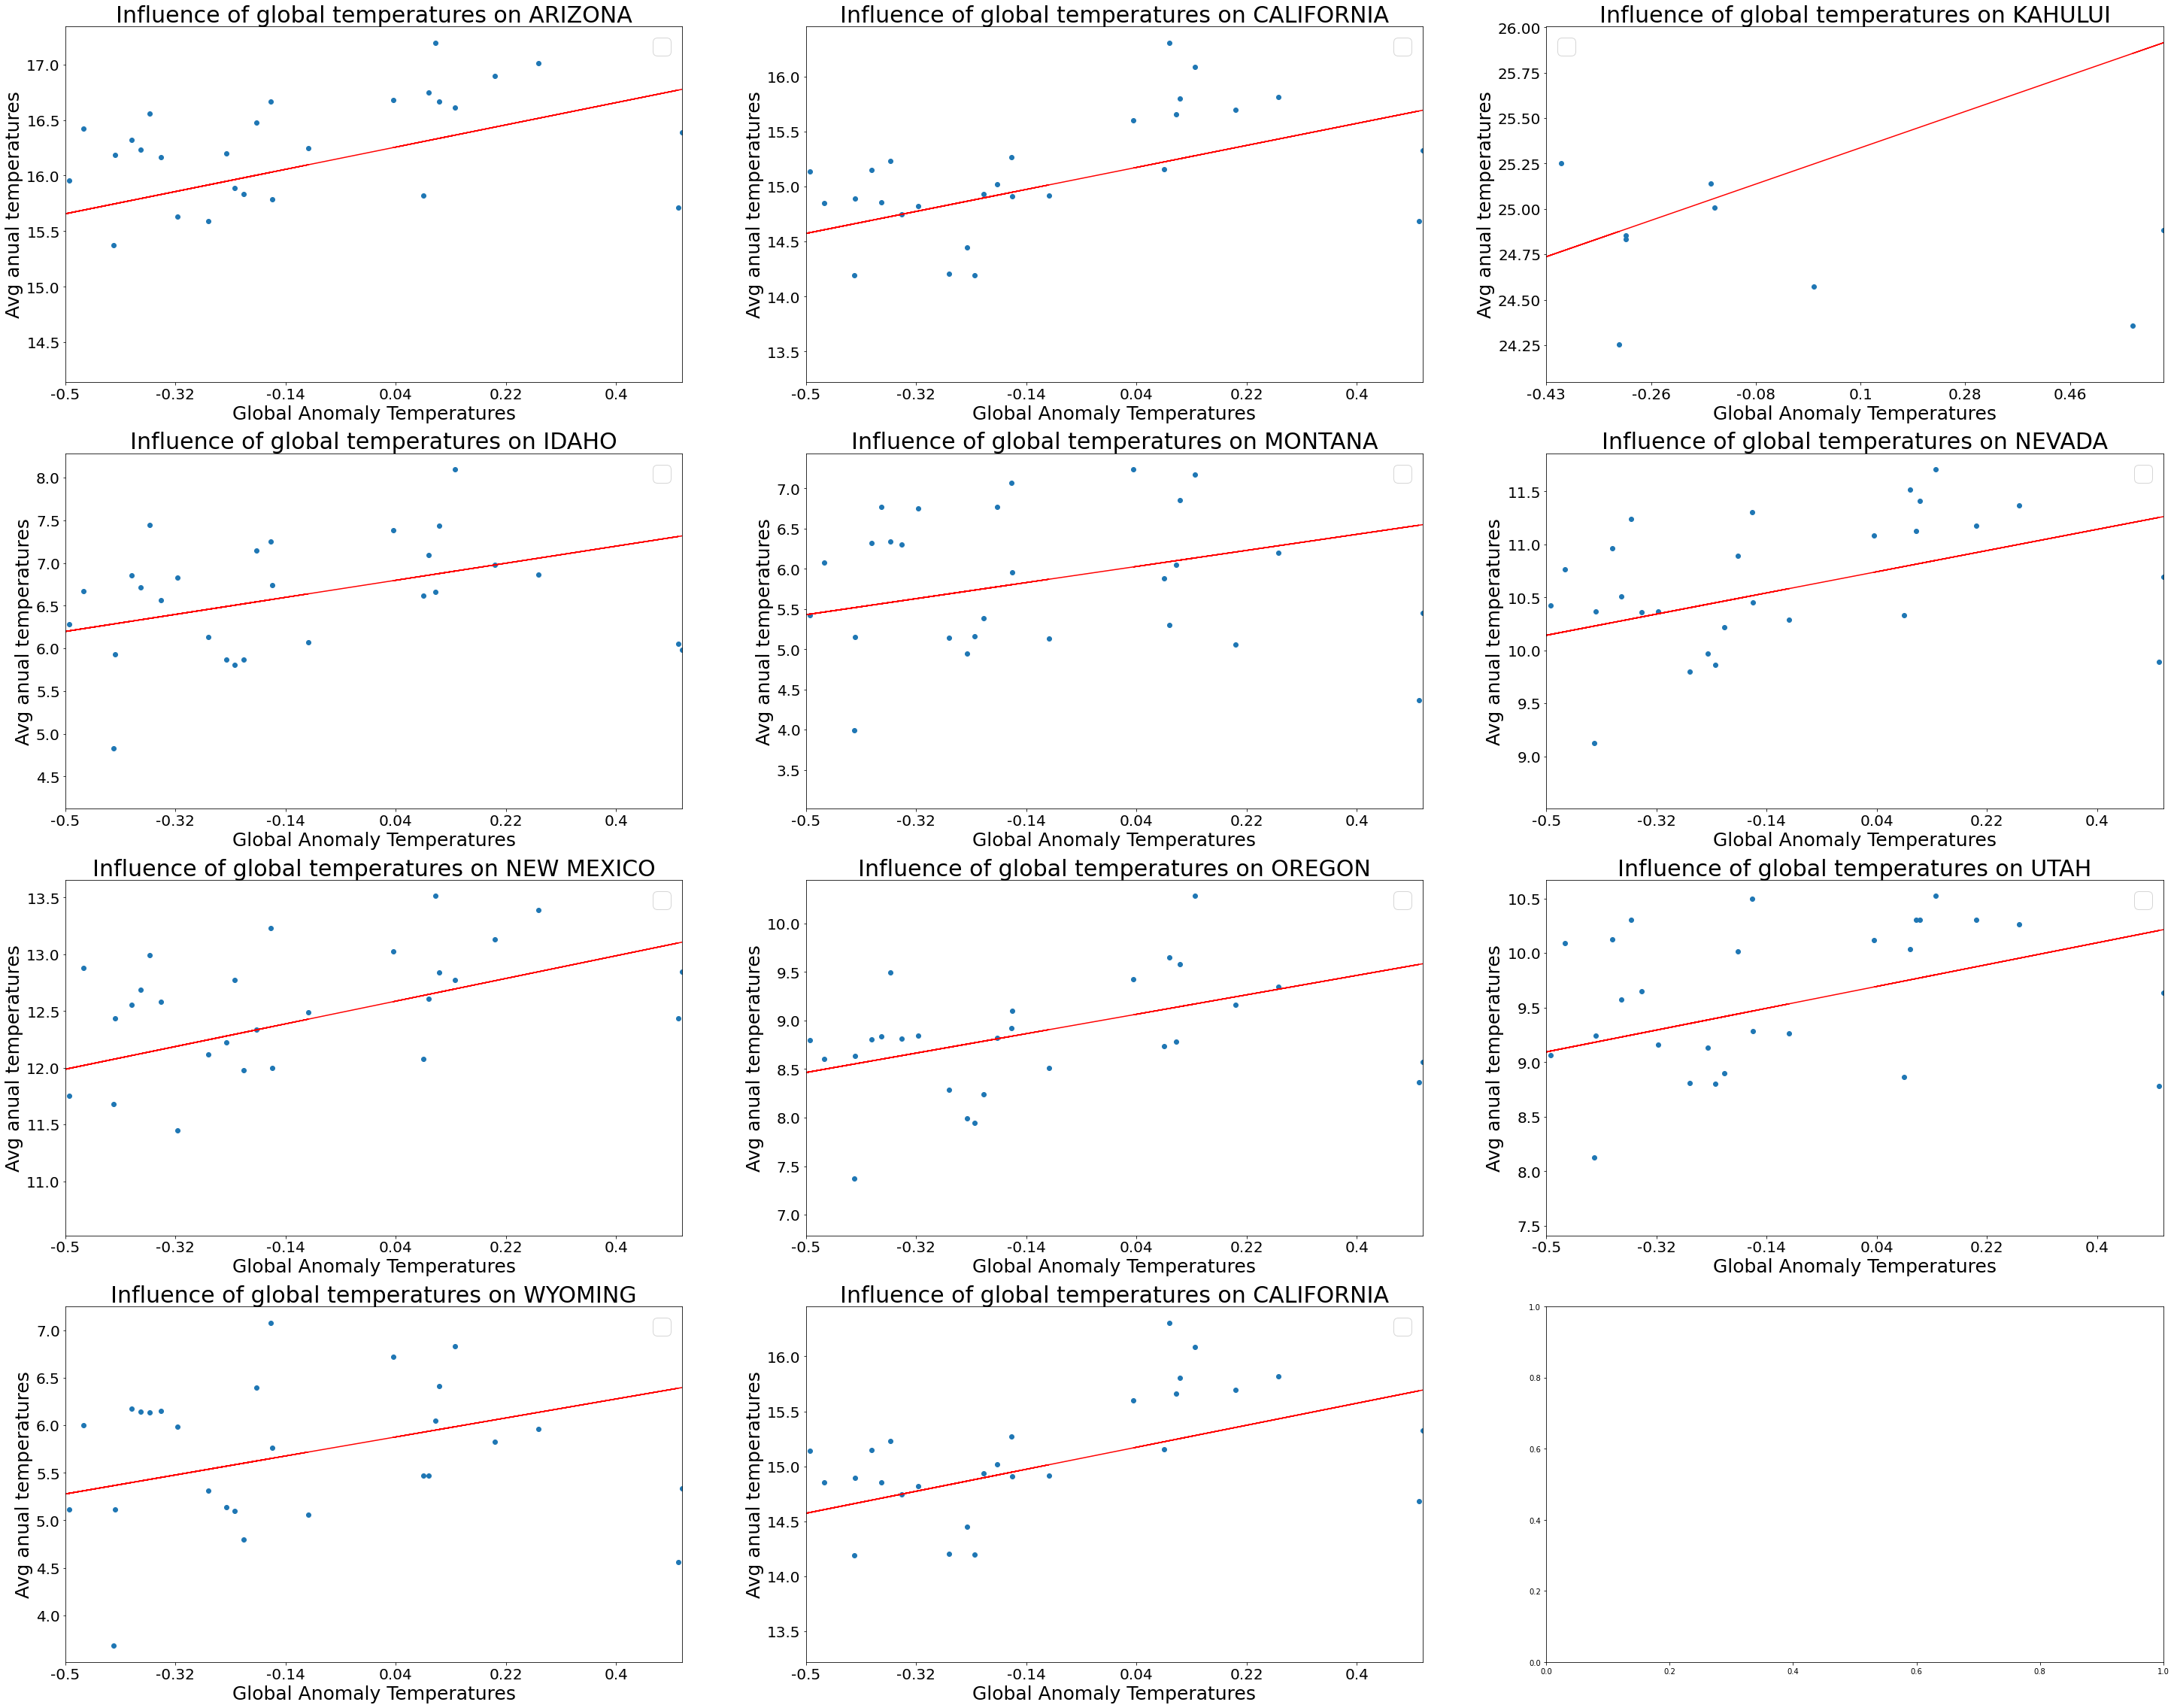

In [18]:
fig, axs = plt.subplots(4,3, figsize=figsize)
axs = [ax for axs_lst in axs for ax in axs_lst]

for i,state in  enumerate(US_west_states): 

   
    title  =  'Influence of global temperatures on ' + state.upper()
    # Read the CSV file into a DataFrame
    local_data = LocalAvgAnualTemperatures[LocalAvgAnualTemperatures['name'] == state]

    #calculate trend_line
    
    y = local_data['avg_anual_temperature'].values
    x  = globalAnomalyTemperatures['anomaly'].values
    x,y = resample_toSameSize(x,y)
    
    # Create the bar chart using the DataFrame and the specified axis
    axs[i].scatter(x,y)
    axs[i].plot(x,x + np.mean(y), 'r')

    #set labels and title
    axs[i].set_xlabel('Global Anomaly Temperatures', fontsize=labelsFontSize)
    axs[i].set_ylabel("Avg anual temperatures" , fontsize=labelsFontSize)
    axs[i].set_title(title, fontsize=titleFonteSize)

    # Set the x-axis tick labels
    
    ticks = [round(el, 2 ) for el in np.linspace(np.min(x), np.max(x), 10)]
    axs[i].set_xticklabels(ticks)
    axs[i].set_xlim([0, np.max(x) + 0])



    # Set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)

    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)

    axs[i].legend(fontsize=30)

fig.set_size_inches(50, 40)
plt.savefig(IMAGES_PATH + 'avgAnomalyTemperatures_correlation.png')

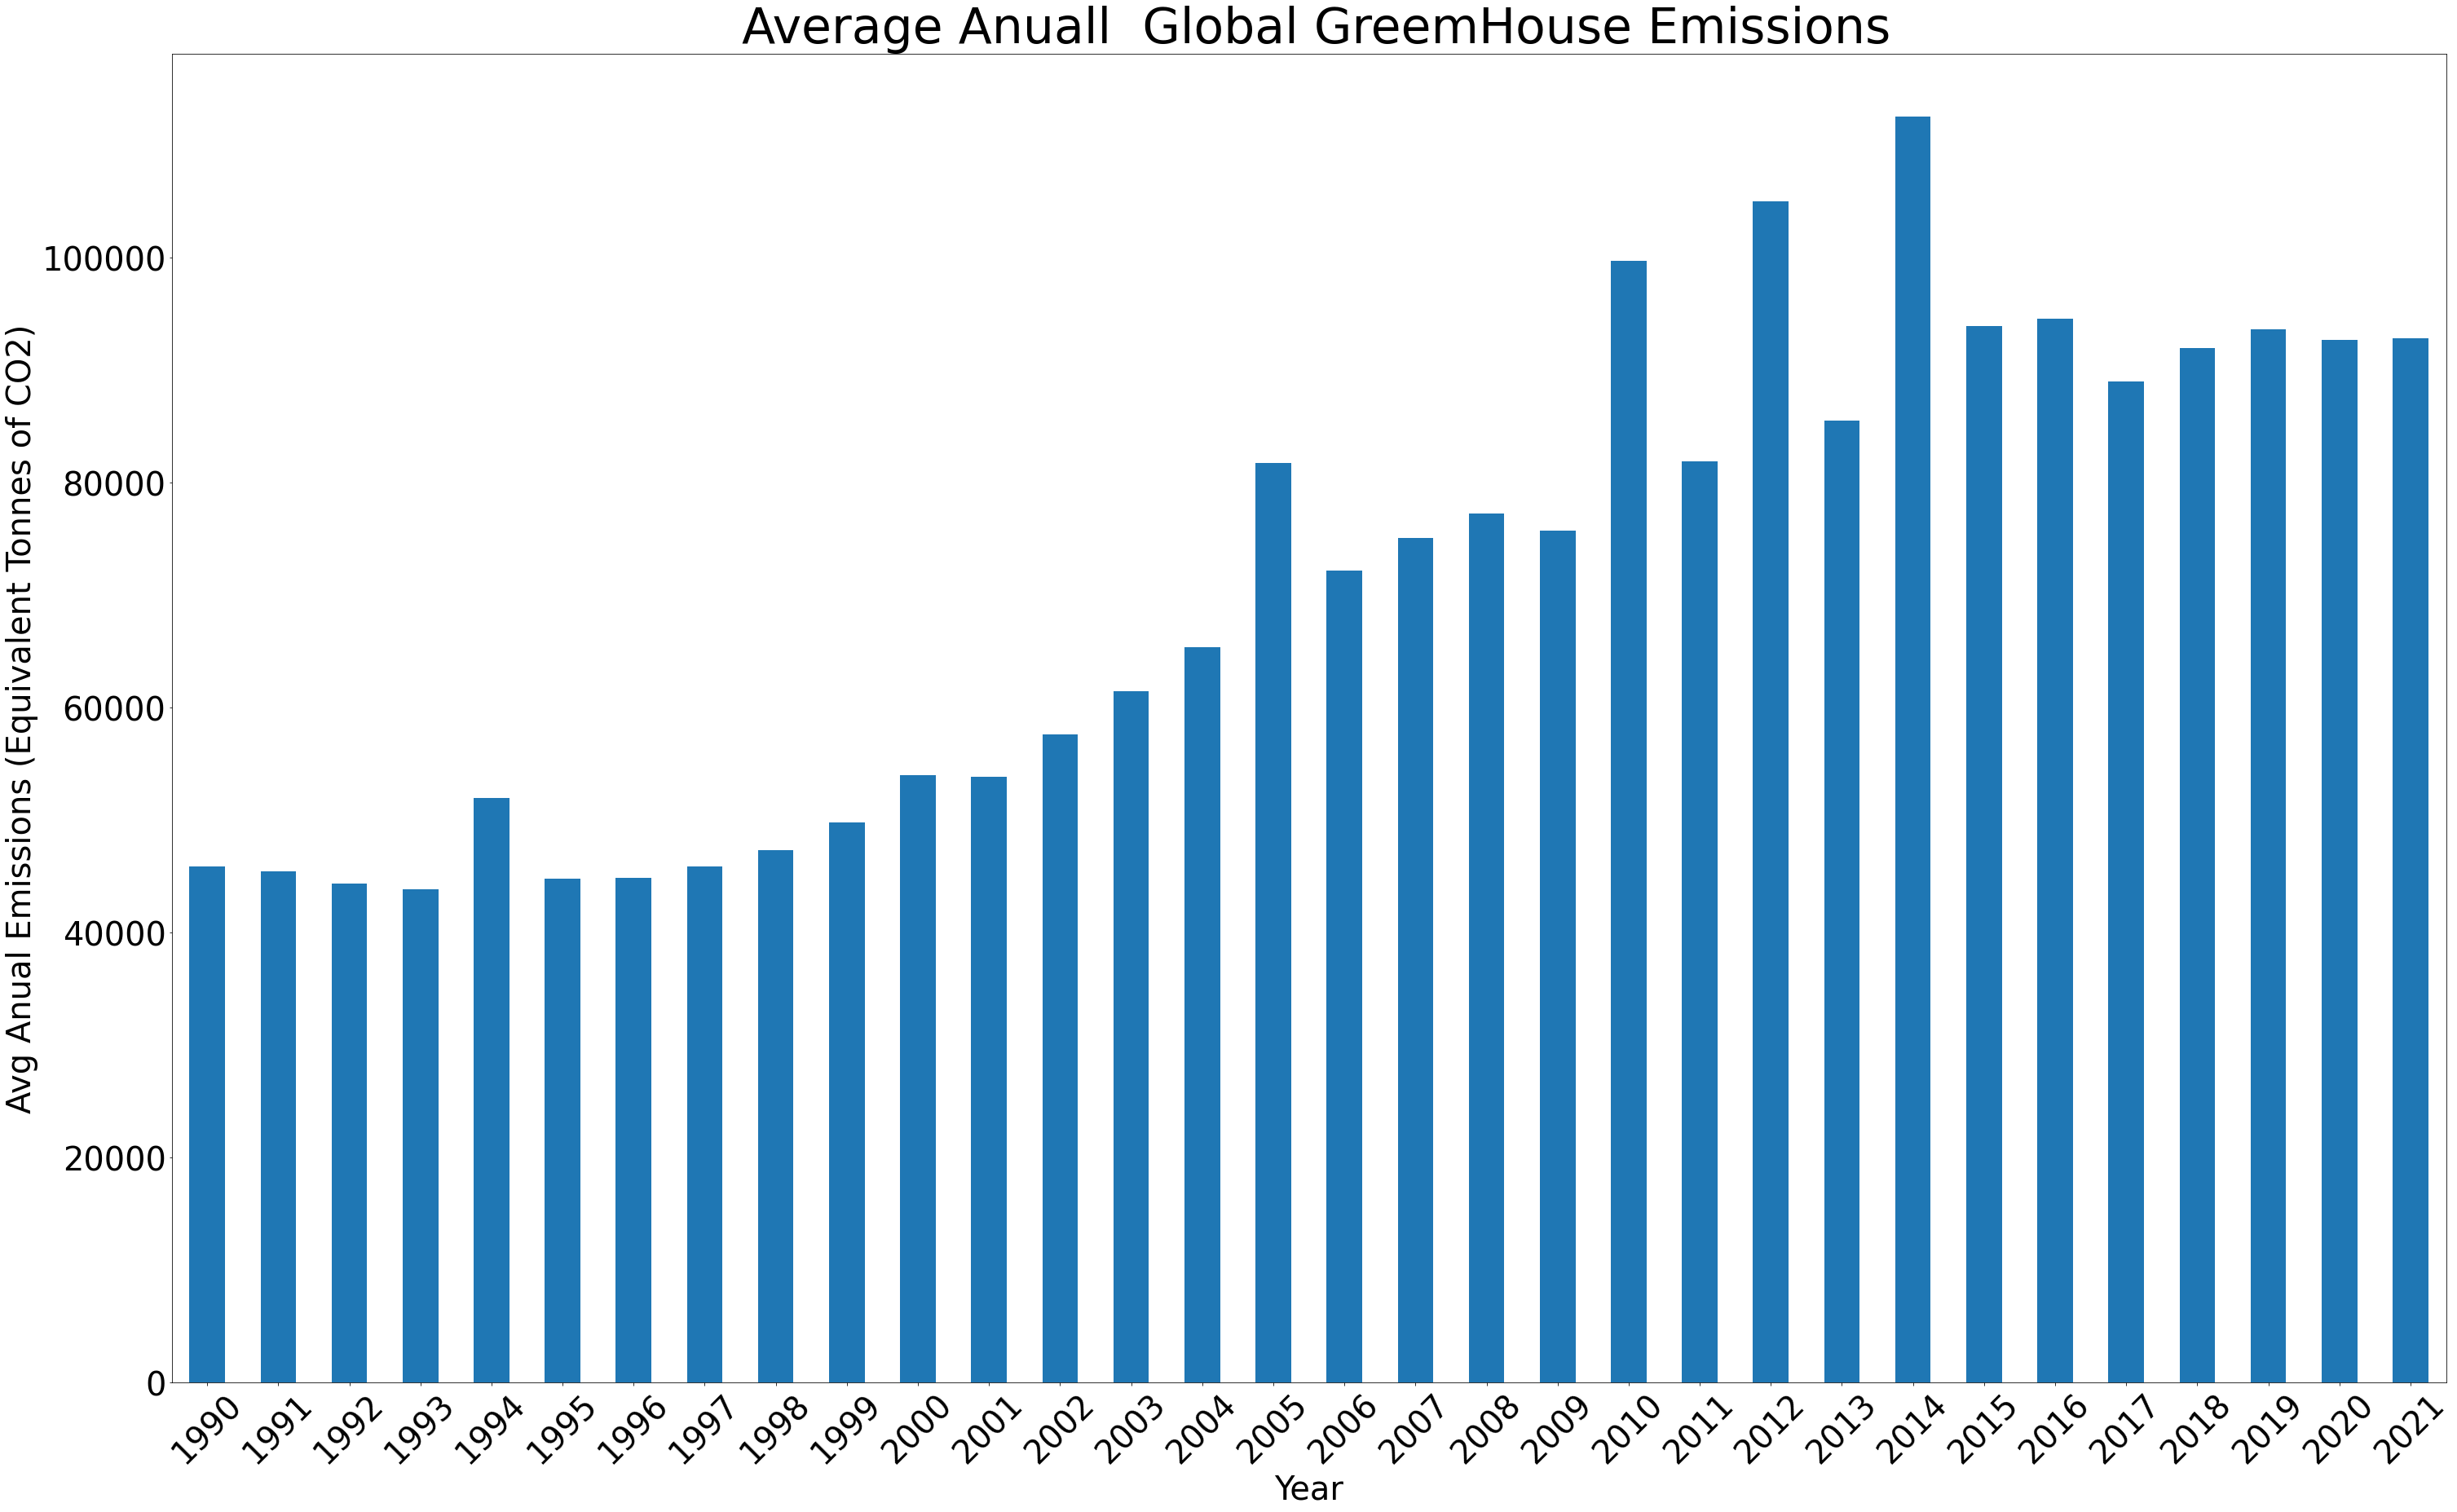

In [19]:
query=f"""
    SELECT 
        YEAR(date) AS year,
        AVG(emission_value) AS avg_anual_emissions
    FROM 
        GreenHouseGasEmissions
    GROUP BY
        YEAR(date)
    ORDER BY
        YEAR(date);
    """
avgAnualGreenhouseEmissions =  pd.read_sql(query, cnxn)
fig, ax  = plot_dfChart(
                avgAnualGreenhouseEmissions, 'year', 'avg_anual_emissions',
                figsize=(30,10), title=" Average Anuall  Global GreemHouse Emissions",
                xLabel='Year', yLabel='Avg Anual Emissions (Equivalent Tonnes of CO2)', chart_type='bar',labelsFontSize=40,
                xLabelRotation=45, ticksFontSize=40, xTicksSpace=1, titleFonteSize=60
             )

#calculate trend_line

fig.set_size_inches(50, 30)
plt.savefig(IMAGES_PATH + 'avgAnualGreenhouseEmissions.png')

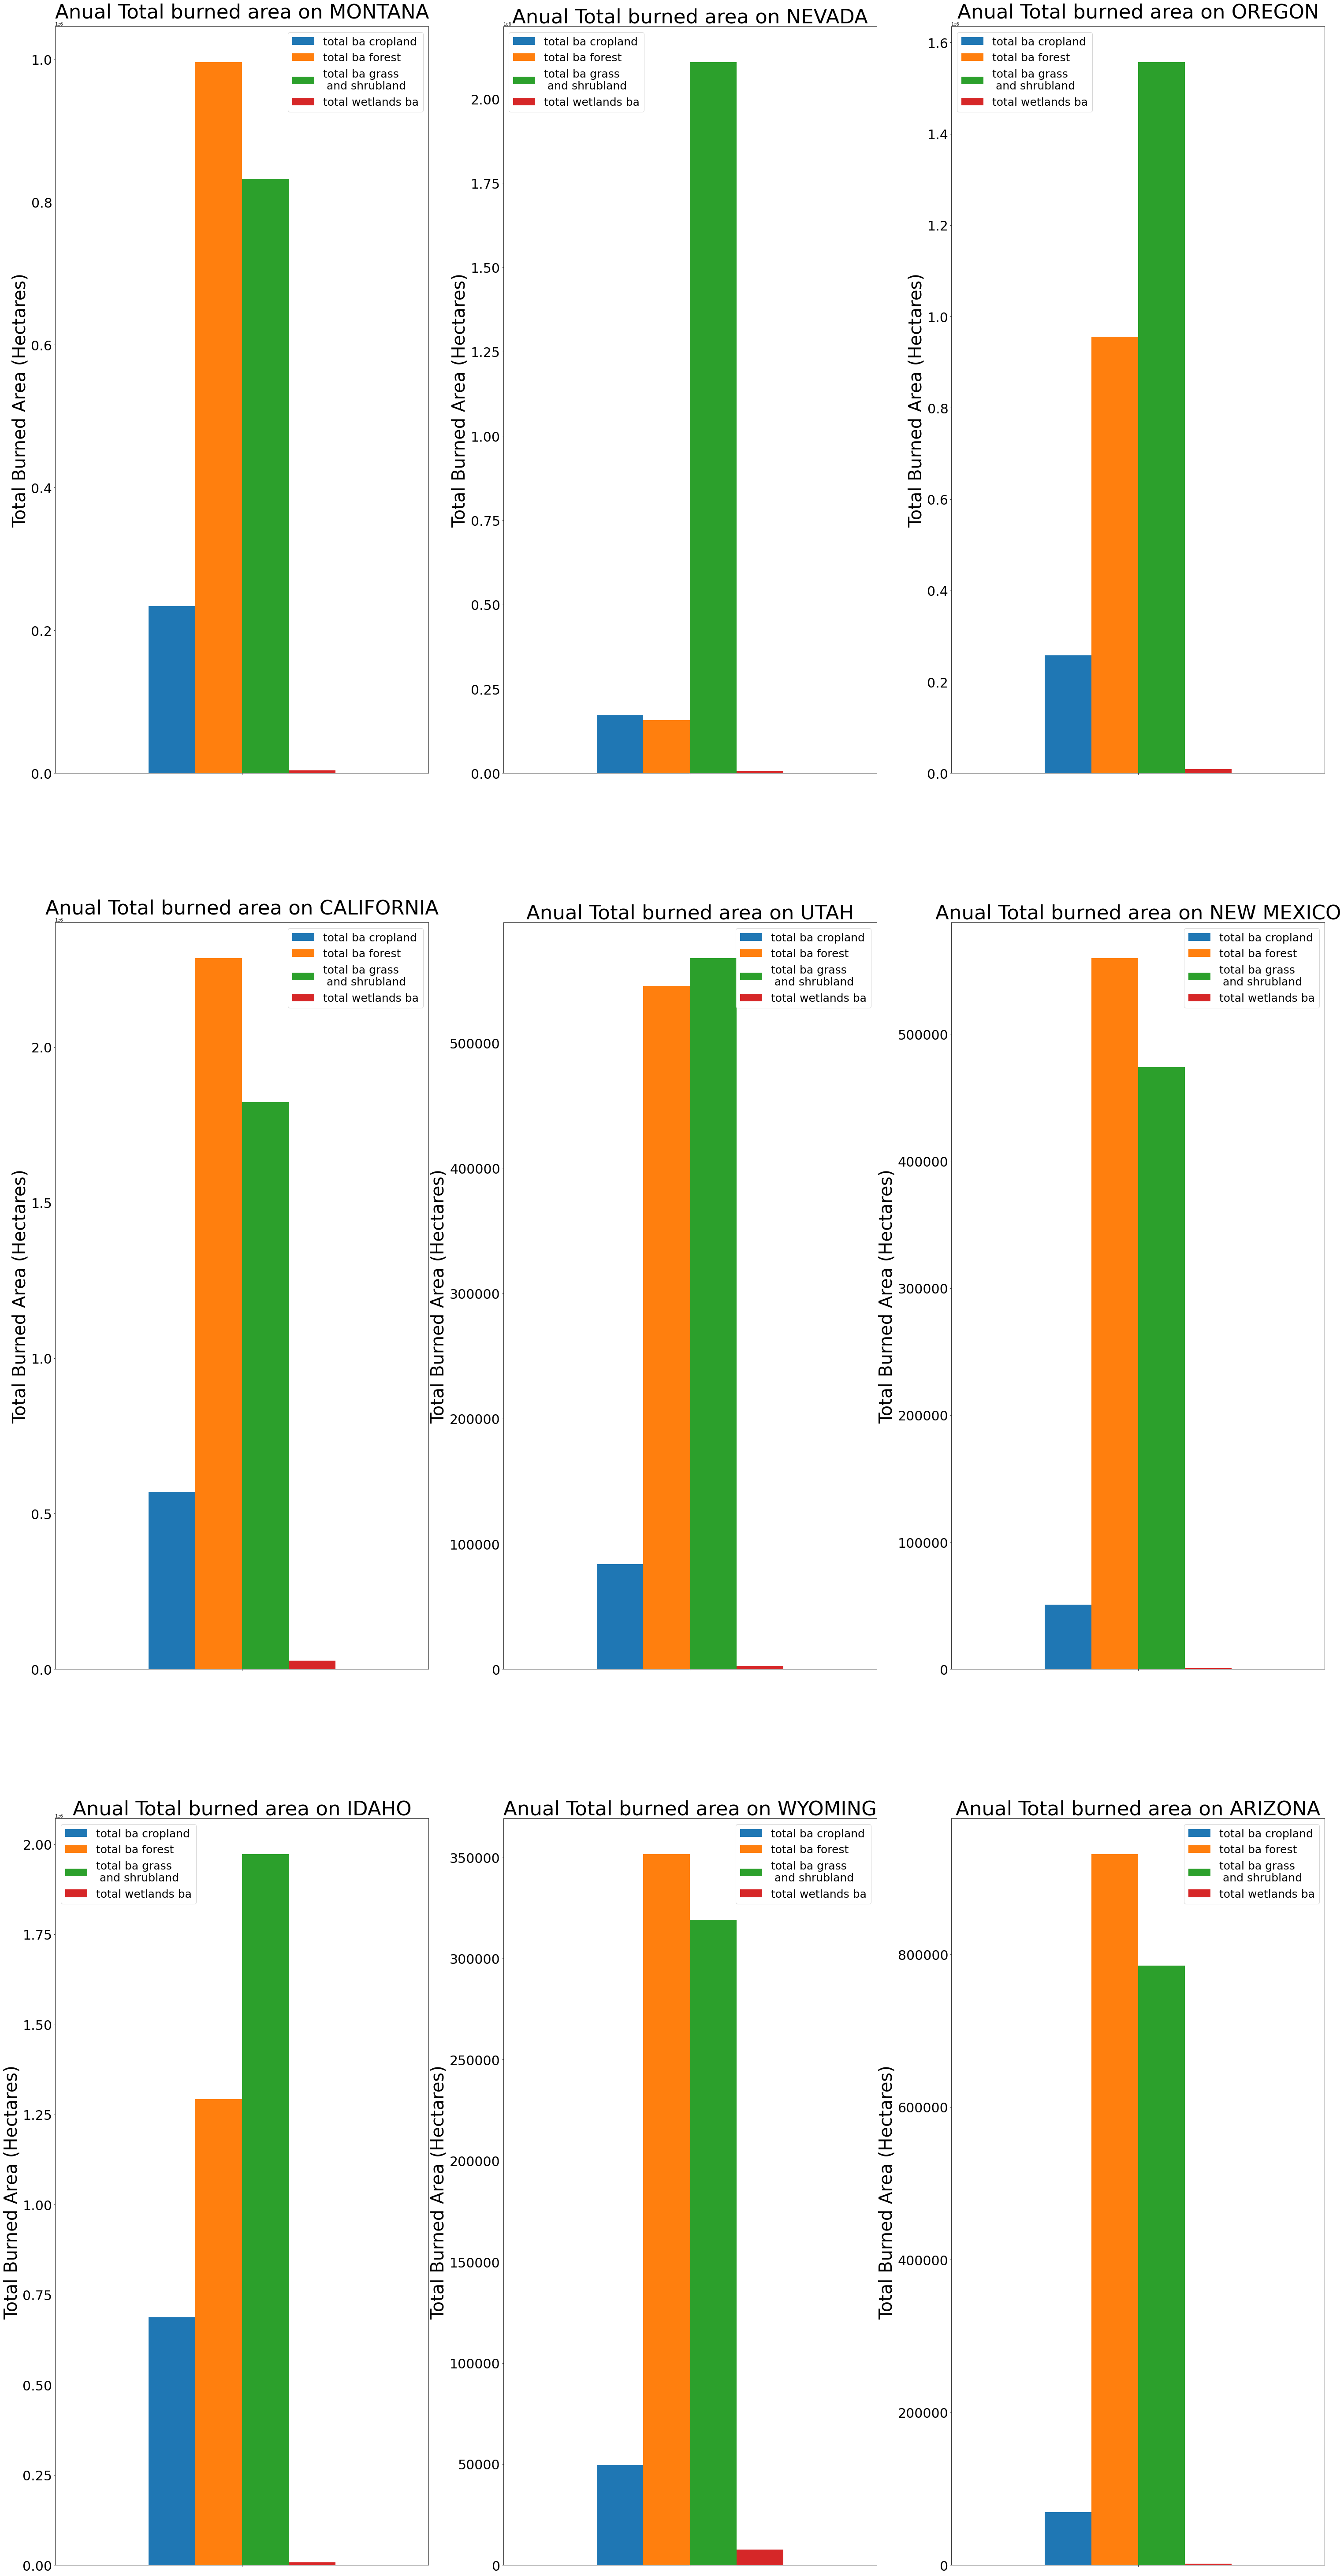

In [40]:
fig, axs = plt.subplots(3,3 )
axs = [ax for axs_lst in axs for ax in axs_lst]
labelsFontSize = 40
titleFonteSize = 45 
xTicksSpace = 1 
xLabelRotation = 45
ticksFontSize = 30


query=f"""
        WITH baWestUSA AS (
            SELECT  
                r.name as west_usa_state,
                ba.date,
                ba.cropland_ba,
                ba.forest_ba,
                ba.grass_and_shrubland_ba,
                ba.wetlands_ba
            FROM 
                BurnedAreaEvolution ba
            INNER JOIN
                Regions r
            ON
                ba.region_code = r.code
            WHERE r.code IN (
                SELECT 
                    code
                FROM 
                    Regions 
                WHERE 
                    name IN ( 
                        'Arizona', 'California', 'Kahului', 
                        'Idaho', 'Montana', 'Nevada',
                        'New Mexico', 'Oregon', 'Utah',
                        'Wyoming', 'California'
                    )
                AND country_code = 'USA'
            )
        )
        SELECT 
            west_usa_state,
            SUM(cropland_ba) AS total_cropland_ba,
            SUM(forest_ba) AS total_forest_ba,
            SUM(grass_and_shrubland_ba) AS total_grass_and_shrubland_ba,
            SUM(wetlands_ba) AS total_wetlands_ba
        FROM
            baWestUSA
        GROUP BY
            west_usa_state;
    """
totalBAWestUSA =  pd.read_sql(query, cnxn)
coverages_ba =['total_cropland_ba', 'total_forest_ba', 'total_grass_and_shrubland_ba','total_wetlands_ba']
west_states =  totalBAWestUSA['west_usa_state'].unique()
for i, state in  enumerate(totalBAWestUSA['west_usa_state'].unique()):
    
    


    #plot
    filter_state = totalBAWestUSA['west_usa_state'] == state
    ax = totalBAWestUSA[filter_state][coverages_ba].plot(kind= 'bar', ax=axs[i], figsize= (45,10))
    ax.legend(['total ba cropland', 'total ba forest', 'total ba grass \n and shrubland', 'total wetlands ba'],fontsize=25)
    # Add labels and title
    axs[i].set_xlabel('', fontsize=labelsFontSize, labelpad=10)
    axs[i].set_ylabel('Total Burned Area (Hectares)', fontsize=labelsFontSize)
    axs[i].set_title(f'Anual Total burned area on {state.upper()}', fontsize=titleFonteSize)

    # Set the x-axis tick labels
    xticks = ''
    axs[i].set_xticklabels(xticks, rotation=xLabelRotation)


    #set labelsFontsize
    axs[i].tick_params(axis='both', labelsize=ticksFontSize)
    plt.subplots_adjust(left=0.1, right=0.9, top=2, bottom=0.4)

#savefig
fig.set_size_inches(50, 50)
fig.savefig(IMAGES_PATH + 'total_ba_coverage_west_usa.png', dpi=300, bbox_inches='tight')

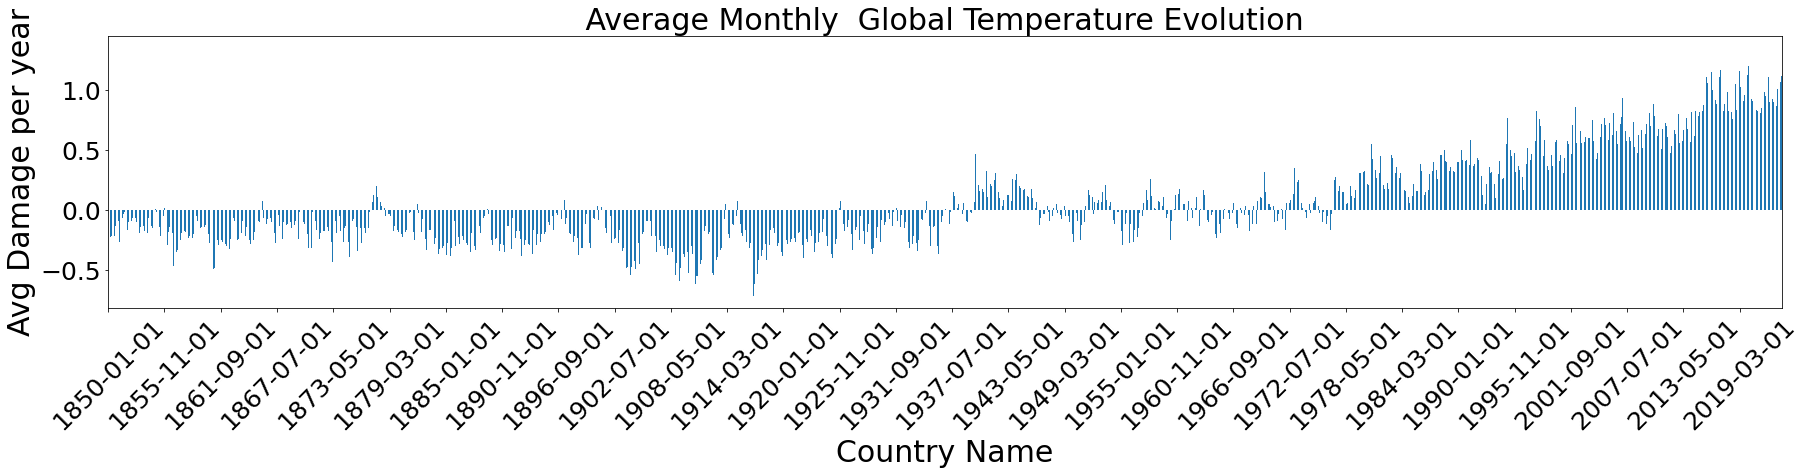

In [49]:
query=f"""
SELECT
     * 
FROM 
    GlobalAnomalyTemperatures 
WHERE 
    coverage='land and sea' 
ORDER BY 
    date;
    """
globalAnomalyTemperatures =  pd.read_sql(query, cnxn)
fig, ax  = plot_dfChart(
                globalAnomalyTemperatures, 'date', 'anomaly',
                figsize=(30,5), title=" Average Monthly  Global Temperature Evolution ",
                xLabel='Country Name', yLabel='Avg Damage per year', chart_type='bar',
                xLabelRotation=45, ticksFontSize=25, xTicksSpace=70, titleFonteSize=30
             )
